In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import statistics
import math
from sklearn import preprocessing
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
import reverse_geocoder as rg
import unicodedata
from datetime import datetime
from geopy import distance
import random

In [76]:
with open('data/data_venues_concerts_artists.csv', encoding='utf-8') as file:
    concerts_artists_df = pd.read_csv(file, index_col=0)
    
with open('data/full_data.csv', encoding='utf-8') as file:
    full_data_df = pd.read_csv(file, index_col=0)
    
with open('data/songkick/data_songkick_concerts_light.csv', encoding='utf-8') as file:
    concerts_df = pd.read_csv(file, index_col=0)
    #concerts_df.index.name = 'concert_id'
    
with open('data/songkick/data_songkick_venues_light_coord.csv', encoding='utf-8') as file:
    venues_df = pd.read_csv(file, index_col=0)
    #venues_df.index.name = 'venue_id'
    
with open('data/songkick/data_songkick_artists.csv', encoding='utf-8') as file:
    songkick_artists_df = pd.read_csv(file, index_col=0)
    
with open('data/spotify/data_spotify_artists_light.csv', encoding='utf-8') as file:
    artists_df = pd.read_csv(file, index_col=0)
    artists_df.index.name = 'artist_id'

with open('data/spotify/data_spotify_top_genres_final.csv', encoding='utf-8') as file:
    spotify_genres_df = pd.read_csv(file, index_col=0)
    
with open('data/wikidata/data_wikidata_top_genres.csv', encoding='utf-8') as file:
    wikidata_genres_df = pd.read_csv(file, index_col=0)
    
with open('data/wikidata/data_wikidata_unique_top_genres_manual.csv', encoding='utf-8') as file:
    wikidata_unique_genres_df = pd.read_csv(file, index_col=0)
    
with open('data/wikidata/data_wikidata_top_genres_list_manual.csv', encoding='utf-8') as file:
    wikidata_manual_top_genres_df = pd.read_csv(file, index_col=0)

print('loaded')
venues_df

loaded


,venue_id,linked_venue_id,venue,locality,latitude,longitude,auto_coord
0,/venues/2351864,/venues/2351864,"""Moon and Stars"" Open Air",Locarno,46.166390,8.799720,1.0
1,/venues/1265176,/venues/1265176,'mischkult-kultur Am Mischpult' on Rabe Radio ...,Bern,46.950830,7.438610,1.0
2,/venues/2311809,/venues/2311809,1 to 1 Energy Happening,Lyss,47.075000,7.306940,1.0
3,/venues/2938518,/venues/2938518,1. Mai-feier,Bern,46.759740,7.628690,NaN
4,/venues/613866,/venues/613866,1. Stock,Basel,47.554069,7.581416,1.0
...,...,...,...,...,...,...,...
7652,/venues/4389762,/venues/4389762,"Überseh-Bar, Villmergen b. Wohlen",Wohlen,47.344660,8.236880,NaN
7653,/venues/3316569,/venues/3316569,Üdiker-Huus,Zürich,47.303170,8.448790,NaN
7654,/venues/4358358,/venues/4358358,à la cArte,Langenthal,47.211920,7.789240,NaN
7655,/venues/4392674,/venues/4392674,à propos festival,Bern,46.950830,7.438610,1.0


In [80]:
artists_df.loc[artists_df.duplicated(subset=['spotify_name'], keep=False)].dropna(subset=['spotify_name'])

,artist_id,linked_artist_id,artist_name,spotify_name,spotify_id,spotify_followers,spotify_listeners
artist_id,,,,,,,
6,/artists/8375378-agcrew,/artists/555641-acres,#AGCrew,Acres,3y43zXffnLmhyQD1K4QCmD,17807.0,26900.0
10,/artists/7958443-and-the-calling-sirens,/artists/1850222-calling-sirens,& The Calling Sirens,The Calling Sirens,1ORY7bHVmnSxZ82DWV6So9,77.0,27.0
79,/artists/9804639-22-halo,/artists/9804639-22-halo,22 Halo,22º Halo,6p355yiyJc67iSNeWLM8WH,1179.0,2700.0
81,/artists/10119580-22deg-halo,/artists/9804639-22-halo,22° Halo,22º Halo,6p355yiyJc67iSNeWLM8WH,1179.0,2700.0
196,/artists/6506249-a-crashed-blackbird-called-ro...,/artists/6506249-a-crashed-blackbird-called-ro...,A Crashed Blackbird Called Rosehip,A Crashed Blackbird Called Rosehip,1NKizqgwDCXtUbMHeqA2Tv,91.0,831.0
...,...,...,...,...,...,...,...
32112,/artists/1850222-calling-sirens,/artists/1850222-calling-sirens,the calling sirens,The Calling Sirens,1ORY7bHVmnSxZ82DWV6So9,77.0,27.0
32123,/artists/7973013-thebrats,/artists/7973013-thebrats,thebrats,The Brats,74sKjTQwRZ1QmyCW1tjeGz,513.0,381.0
32212,/artists/4808018-uber-you,/artists/8001758-uberyou,Über You,Überyou,1bWY1OUdZHaLFpOMtpHM7C,1203.0,702.0


## Raw scraping stats
---

In [7]:
with open('data/songkick/data_songkick_artists.csv', encoding='utf-8') as file:
    artists_df = pd.read_csv(file, index_col=0)
    
with open('data/songkick/data_songkick_concerts.csv', encoding='utf-8') as file:
    concerts_df = pd.read_csv(file, index_col=0)

with open('data/songkick/data_songkick_venues.csv', encoding='utf-8') as file:
    venues_df = pd.read_csv(file, index_col=0)
    
with open('data/songkick/data_songkick_venues_no_duplicate.csv', encoding='utf-8') as file:
    venues_no_duplicate_df = pd.read_csv(file, index_col=0)

c:\users\cyrille\google drive\unil\ish\mémoire\thesis\env\lib\site-packages\IPython\core\interactiveshell.py:3172: DtypeWarning: Columns (22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
print('Raw data after scraping')
print('Nbr concerts:', len(concerts_df))
print('Nbr artists:', len(artists_df))
print('Nbr venues:', len(venues_df))
print('Nbr venues no duplicate:', venues_no_duplicate_df['linked_venue_id'].nunique())

Raw data after scraping
Nbr concerts: 82011
Nbr artists: 32231
Nbr venues: 7657
Nbr venues no duplicate: 7234


## Songkick pre-processing stats
---

In [ ]:
with open('data/songkick/data_songkick_venues', encoding='utf-8') as file:
    venues_df = pd.read_csv(file, index_col=0)

## Coordinates
---

In [87]:
coordinates = (46.61671, 6.64496)
rg.search(coordinates)

[{'lat': '46.61596',
  'lon': '6.66149',
  'name': 'Bottens',
  'admin1': 'Vaud',
  'admin2': 'Gros-de-Vaud District',
  'cc': 'CH'}]

In [29]:
with open('data/CH.csv', encoding='utf-8') as file:
    localities_df = pd.read_csv(file, error_bad_lines=False, sep=';')

localities_df

,EGID,GDEKT,GDENR,GDENAME,GSTAT,GSTATLAB_DE,GSTATLAB_FR,GSTATLAB_IT,GKODE,GKODN,...,STRNAME,DEINR,STRSP,DPLZ4,DPLZZ,DPLZNAME,DKODE,DKODN,DOFFADR,DEXPDAT
0,1,ZH,2.0,Affoltern am Albis,1004.0,bestehend,existant,esistente,2676465.140,1235849.103,...,Grossholzerstrasse,20,DE,8910,0,Affoltern am Albis,2676465.141,1235849.103,0,2021-11-12 00:00:00
1,10,ZH,2.0,Affoltern am Albis,1004.0,bestehend,existant,esistente,2676440.038,1235973.538,...,Im Feld,9,DE,8910,0,Affoltern am Albis,2676444.333,1235975.496,0,2021-11-12 00:00:00
2,100,ZH,2.0,Affoltern am Albis,1004.0,bestehend,existant,esistente,2676765.706,1236101.658,...,Hasenbühlstrasse,17,DE,8910,0,Affoltern am Albis,2676768.763,1236102.071,0,2021-11-12 00:00:00
3,10000,ZH,30.0,Andelfingen,1004.0,bestehend,existant,esistente,2693391.650,1272255.267,...,Obermühlestrasse,7,DE,8450,0,Andelfingen,2693387.845,1272250.319,0,2021-11-12 00:00:00
4,1000001,GE,6602.0,Anières,1004.0,bestehend,existant,esistente,2506071.380,1125077.000,...,Chemin des Avallons,2,FR,1247,0,Anières,2506079.092,1125072.483,0,2021-11-12 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779162,99994,ZH,198.0,Uster,1004.0,bestehend,existant,esistente,2696705.683,1245022.556,...,Bahnhofstrasse,12,DE,8610,0,Uster,2696701.236,1245026.105,0,2021-11-12 00:00:00
2779163,99995,ZH,198.0,Uster,1004.0,bestehend,existant,esistente,2696792.976,1245085.637,...,Bahnhofstrasse,3,DE,8610,0,Uster,2696789.652,1245081.951,0,2021-11-12 00:00:00
2779164,99996,ZH,198.0,Uster,1004.0,bestehend,existant,esistente,2696718.474,1245039.536,...,Bahnhofstrasse,10,DE,8610,0,Uster,2696715.489,1245043.901,0,2021-11-12 00:00:00
2779165,99997,ZH,198.0,Uster,1004.0,bestehend,existant,esistente,2696722.040,1245043.472,...,Bahnhofstrasse,8,DE,8610,0,Uster,2696716.688,1245045.502,0,2021-11-12 00:00:00


In [57]:
with open('data/data_ofsp_communes.csv', encoding='utf-8') as file:
    communes_df = pd.read_csv(file)
    
communes_df

,Number of commune,Name of commune,Residents,Change in %,Population density per km²,Foreign nationals in %,0-19 years,20-64 years,65 years or over,Crude marriage rate,...,FDP/PLR 2),CVP,SP,SVP,EVP/CSP,GLP,BDP,PdA/Sol.,GPS,Small right-wing parties
0,NaN,Switzerland,8'606'033,9.4,215,25.3,20.0,61.4,18.7,4.5,...,15.1,11.4,16.8,25.6,2.3,7.8,2.4,1.0,13.2,2.1
1,1.0,Aeugst am Albis,1'981,8.6,250,14.2,19.8,62.2,18.0,7.1,...,16.4,2.5,11.6,30.4,3.2,14.3,1.3,0.2,15.1,3.8
2,2.0,Affoltern am Albis,12'303,10.9,1'162,28.7,20.2,61.7,18.2,5.5,...,13.4,4.5,14.6,30.3,6.6,12.7,2.0,0.2,12.6,1.6
3,3.0,Bonstetten,5'572,8.0,750,16.6,23.6,59.8,16.5,4.3,...,15.4,3.9,16.7,26.1,4.2,16.2,1.3,0.2,12.4,1.4
4,4.0,Hausen am Albis,3'751,11.6,276,16.0,22.2,59.8,18.0,3.2,...,11.1,3.9,13.7,33.2,4.1,12.4,1.6,0.2,16.7,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2168,6806.0,Vendlincourt,559,1.8,61,7.2,18.4,56.9,24.7,7.3,...,19.1,22.8,17.9,21.2,9.8,*,*,*,9.3,*
2169,6807.0,Basse-Allaine,1'238,-5.3,54,9.1,21.7,53.0,25.3,4.1,...,13.8,40.1,23.6,11.7,3.8,*,*,*,7.0,*
2170,6808.0,Clos du Doubs,1'263,0.2,20,7.3,18.3,56.6,25.1,3.1,...,4.5,33.3,21.6,14.3,10.2,*,*,*,16.1,*
2171,6809.0,Haute-Ajoie,1'085,-6.1,27,8.4,17.8,55.5,26.7,5.5,...,8.4,37.9,19.4,18.7,4.2,*,*,*,11.5,*


In [59]:
# remove accents and uppercase letters
localities_df['locality_formatted'] = localities_df['DPLZNAME'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.lower()
communes_df['commune_formatted'] = communes_df['Name of commune'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.lower()
communes_df

,Number of commune,Name of commune,Residents,Change in %,Population density per km²,Foreign nationals in %,0-19 years,20-64 years,65 years or over,Crude marriage rate,...,CVP,SP,SVP,EVP/CSP,GLP,BDP,PdA/Sol.,GPS,Small right-wing parties,commune_formatted
0,NaN,Switzerland,8'606'033,9.4,215,25.3,20.0,61.4,18.7,4.5,...,11.4,16.8,25.6,2.3,7.8,2.4,1.0,13.2,2.1,switzerland
1,1.0,Aeugst am Albis,1'981,8.6,250,14.2,19.8,62.2,18.0,7.1,...,2.5,11.6,30.4,3.2,14.3,1.3,0.2,15.1,3.8,aeugst am albis
2,2.0,Affoltern am Albis,12'303,10.9,1'162,28.7,20.2,61.7,18.2,5.5,...,4.5,14.6,30.3,6.6,12.7,2.0,0.2,12.6,1.6,affoltern am albis
3,3.0,Bonstetten,5'572,8.0,750,16.6,23.6,59.8,16.5,4.3,...,3.9,16.7,26.1,4.2,16.2,1.3,0.2,12.4,1.4,bonstetten
4,4.0,Hausen am Albis,3'751,11.6,276,16.0,22.2,59.8,18.0,3.2,...,3.9,13.7,33.2,4.1,12.4,1.6,0.2,16.7,1.6,hausen am albis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2168,6806.0,Vendlincourt,559,1.8,61,7.2,18.4,56.9,24.7,7.3,...,22.8,17.9,21.2,9.8,*,*,*,9.3,*,vendlincourt
2169,6807.0,Basse-Allaine,1'238,-5.3,54,9.1,21.7,53.0,25.3,4.1,...,40.1,23.6,11.7,3.8,*,*,*,7.0,*,basse-allaine
2170,6808.0,Clos du Doubs,1'263,0.2,20,7.3,18.3,56.6,25.1,3.1,...,33.3,21.6,14.3,10.2,*,*,*,16.1,*,clos du doubs
2171,6809.0,Haute-Ajoie,1'085,-6.1,27,8.4,17.8,55.5,26.7,5.5,...,37.9,19.4,18.7,4.2,*,*,*,11.5,*,haute-ajoie


In [89]:
# remove accents from string and set to lowercase

def normalize_string(text):
    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    
    normalized_string = str(text).lower()

    return normalized_string

In [91]:
# data for localities_df: https://www.bfs.admin.ch/bfs/fr/home/bases-statistiques/repertoire-officiel-communes-suisse/tableau-correspondance-regbl.html
# name of localities_df columns: https://www.ech.ch/fr/dokument/1096043c-de44-4761-9b87-c4486c3454f8
# data for communes_df: https://www.bfs.admin.ch/bfs/fr/home/bases-statistiques/repertoire-officiel-communes-suisse.assetdetail.17884688.html
# data for reverse geolocation: http://download.geonames.org/export/dump/

for idx, row in venues_df.iloc[2350:2400].iterrows():
    songkick_venue = row['venue']
    songkick_locality = row['locality']
    lat = row['latitude']
    lon = row['longitude']
    
    if pd.notna(lat):
        locality = rg.search((lat, lon))
        geo_locality = locality[0]['name']
        geo_canton = locality[0]['admin1']
        geo_locality = normalize_string(geo_locality)
        
        # replace zurich neighborhoods "zuerich (kreis xx)" by "zurich"
        if 'zuerich (kreis' in geo_locality:
            geo_locality = 'zurich'
        
        if len(communes_df.loc[communes_df['commune_formatted'] == geo_locality]) > 0:
            print('commune')
        elif len(localities_df.loc[localities_df['locality_formatted'] == geo_locality]) > 0:
            print('locality')
        else:
            # search
            contain_commune = communes_df.loc[communes_df['commune_formatted'].str.contains(geo_locality, case=False)]
            if len(contain_commune) > 0:
                print(songkick_venue, '--', songkick_locality, '->', geo_locality, geo_canton)
                print(contain_commune['commune_formatted'])
                continue
            
            contain_locality = localities_df.loc[localities_df['locality_formatted'].str.contains(geo_locality, case=False)]
            if len(contain_locality) > 0:
                print(songkick_venue, '--', songkick_locality, '->', geo_locality)
                print(contain_locality['locality_formatted'][0])
            else:
                print(songkick_venue, '--', songkick_locality, '->', geo_locality)
        

commune
commune
commune
commune
commune
Hornareal -- Zürich -> richterswil / dorfkern
commune
locality
commune
commune
commune
commune
commune
commune
commune
commune
commune
Sound Arena -- Wohlen -> wohlen Aargau
203     wohlen bei bern
1251       wohlenschwil
1274        wohlen (ag)
Name: commune_formatted, dtype: object
commune
Kulturkeller Custorhaus -- Eschenbach -> eschenbach Saint Gallen
184         oeschenbach
514     eschenbach (lu)
1089    eschenbach (sg)
Name: commune_formatted, dtype: object
commune
commune
commune
commune
commune
commune
commune
commune
commune
commune
commune


In [50]:
localities_df.loc[localities_df['DPLZNAME'] == 'Biel/Bienne']
#communes_df.loc[communes_df['Name of commune'] == 'Fiesch']

,EGID,GDEKT,GDENR,GDENAME,GSTAT,GSTATLAB_DE,GSTATLAB_FR,GSTATLAB_IT,GKODE,GKODN,...,STRNAME,DEINR,STRSP,DPLZ4,DPLZZ,DPLZNAME,DKODE,DKODN,DOFFADR,DEXPDAT
213898,11513808,BE,371.0,Biel/Bienne,1004.0,bestehend,existant,esistente,2583214.528,1219969.545,...,Chemin des Bourguignons,32a,FR,2505,0,Biel/Bienne,2583213.309,1219976.167,1,2021-11-12 00:00:00
213899,11513808,BE,371.0,Biel/Bienne,1004.0,bestehend,existant,esistente,2583214.528,1219969.545,...,Burgunderweg,32a,DE,2505,0,Biel/Bienne,2583213.309,1219976.167,1,2021-11-12 00:00:00
213900,11513811,BE,371.0,Biel/Bienne,1004.0,bestehend,existant,esistente,2585837.257,1220870.502,...,Rue des Diamants,24,FR,2503,0,Biel/Bienne,2585835.456,1220874.786,1,2021-11-12 00:00:00
213901,11513811,BE,371.0,Biel/Bienne,1004.0,bestehend,existant,esistente,2585837.257,1220870.502,...,Diamantstrasse,24,DE,2503,0,Biel/Bienne,2585835.456,1220874.786,1,2021-11-12 00:00:00
213902,11513814,BE,371.0,Biel/Bienne,1004.0,bestehend,existant,esistente,2586887.062,1221943.011,...,Chemin de la Prévôté,3c,FR,2504,0,Biel/Bienne,2586891.418,1221946.543,1,2021-11-12 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2701318,9081692,BE,371.0,Biel/Bienne,1004.0,bestehend,existant,esistente,2588035.767,1223302.354,...,Solothurnstrasse,132,DE,2504,0,Biel/Bienne,2588031.008,1223298.042,1,2021-11-12 00:00:00
2701319,9081694,BE,371.0,Biel/Bienne,1004.0,bestehend,existant,esistente,2585425.651,1221143.622,...,Rue Basse,1,FR,2502,0,Biel/Bienne,2585430.146,1221138.978,1,2021-11-12 00:00:00
2701320,9081694,BE,371.0,Biel/Bienne,1004.0,bestehend,existant,esistente,2585425.651,1221143.622,...,Untergasse,1,DE,2502,0,Biel/Bienne,2585430.146,1221138.978,1,2021-11-12 00:00:00
2701321,9081695,BE,371.0,Biel/Bienne,1004.0,bestehend,existant,esistente,2585694.337,1220347.773,...,Rue Centrale,95a,FR,2503,0,Biel/Bienne,2585703.203,1220341.091,1,2021-11-12 00:00:00


## Songkick stats

In [67]:
full_songkick_df = concerts_artists_df.merge(concerts_df[['venue_id', 'startDate']], left_on='concert_id', right_index=True)
full_songkick_df = full_songkick_df.merge(venues_df[['locality', 'longitude', 'latitude']], left_on='venue_id', right_index=True)
full_songkick_df.loc[full_songkick_df['concert_id'] == '/concerts/36259569']

,concert_id,artist_id,venue_id,startDate,locality,longitude,latitude
32066,/concerts/36259569,/artists/8755459-use-fr,/venues/2837343,2019-03-28,Lausanne,6.63141,46.52012
32067,/concerts/36259569,/artists/482962-frustration,/venues/2837343,2019-03-28,Lausanne,6.63141,46.52012


In [36]:
full_songkick_df.count()

concert_id    117760
artist_id     117760
venue_id      117760
startDate     117760
locality      117760
longitude     109292
latitude      109292
dtype: int64

In [39]:
date_filter = full_songkick_df[(full_songkick_df['startDate'] > '2010-01-01') & (full_songkick_df['startDate'] < '2020-01-01')].index
filtered_songkick_df = full_songkick_df.iloc[date_filter]
filtered_songkick_df

,concert_id,artist_id,venue_id,startDate,locality,longitude,latitude
9,/festivals/3250138,/artists/10069604-flavio-stonex,/venues/1943879,2019-10-12,Mels,9.42400,47.04380
10,/concerts/32335899,/artists/11032-jazz-connection,/venues/1943879,2018-08-11,Mels,9.42400,47.04380
11,/concerts/32335884,/artists/11032-jazz-connection,/venues/1943879,2018-08-10,Mels,9.42400,47.04380
12,/concerts/13429724,/artists/2865626-james-lann,/venues/1943879,2012-08-10,Mels,9.42400,47.04380
4,/festivals/3250141,/artists/10069604-flavio-stonex,/venues/2077709,2020-10-17,Mels,NaN,NaN
...,...,...,...,...,...,...,...
117755,/concerts/14836234,/artists/456971-funeral-for-a-friend,/venues/2148724,2013-04-07,Zürich,8.49986,47.38732
117756,/concerts/14836234,/artists/4578008-tidal-sleep,/venues/2148724,2013-04-07,Zürich,8.49986,47.38732
117757,/concerts/14836234,/artists/424864-silverstein,/venues/2148724,2013-04-07,Zürich,8.49986,47.38732
117758,/concerts/16089124,/artists/6316464-vatsgoed,/venues/2148724,2013-04-05,Zürich,8.49986,47.38732


In [41]:
filtered_songkick_df.count()

concert_id    97619
artist_id     97619
venue_id      97619
startDate     97619
locality      97619
longitude     91099
latitude      91099
dtype: int64

## Wikidata stats

In [40]:
wikidata_genres_df.nunique()

genre_id              4579
genre_name            4574
genre_name_edited     4570
top_genre_id          1403
top_genre_name        1403
unique_top_genre         2
everynoise_id         1385
everynoise_name       1385
discogs_genre_name      14
discogs_style_name     555
dtype: int64

In [41]:
wikidata_unique_genres_df['manual_top_genre'].value_counts()
wikidata_unique_genres_df.nunique()

unique_top_genre    128
manual_top_genre     15
dtype: int64

In [18]:
wikidata_unique_genres_df

,unique_top_genre,manual_top_genre
0,absolute music,art music
1,afro,world music
2,afro-peruvian music,world music
3,album-oriented rock,rock music
4,argentine punk,rock music
...,...,...
123,women's music,art music
124,world fusion music,world music
125,xhosa music,folk music
126,yacht rock,rock music


In [46]:
wikidata_manual_top_genres_df.count()

top_genre           48
manual_top_genre    25
dtype: int64

In [20]:
wikidata_manual_top_genres_df.iloc[:10]

,top_genre,manual_top_genre
0,acoustic music,NaN
1,alternative,rock music
2,art music,NaN
3,bhangra,dance music
4,blues,NaN
5,brega,world music
6,children's music,NaN
7,children’s music,children's music
8,comedy music,functional music
9,congolese rumba,world music


In [38]:
spotify_genres_df.nunique()

spotify_genre    3744
top_genre          23
dtype: int64

In [47]:
spotify_genres_df['top_genre'].unique()

array(['art music', 'experimental music', 'rock music', 'hip hop music',
       'world music', 'electronic music', 'vocal music', 'acoustic music',
       'dance music', 'funk', 'rhythm and blues', 'blues', 'pop music',
       'independent music', 'functional music', 'instrumental music',
       'soul music', 'folk music', 'jazz', 'country music',
       'underground music', "children's music", 'lo-fi music'],
      dtype=object)

<AxesSubplot:>

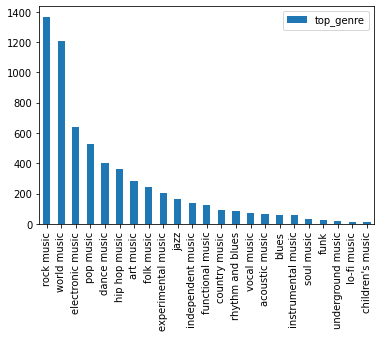

In [36]:
pd.DataFrame(spotify_genres_df['top_genre'].value_counts()).plot.bar()

In [30]:
spotify_genres_df

,spotify_genre,top_genre
0,21st century classical,art music
1,5th wave emo,experimental music
2,5th wave emo,rock music
3,5th wave emo,hip hop music
4,5th wave emo,world music
...,...,...
6175,zim urban groove,world music
6176,zolo,rock music
6177,zouk,world music
6178,zurich indie,world music


## Artists stats
---

In [62]:
artists_matched_df = artists_df.loc[pd.notna(artists_df['spotify_id'])]
spotify_popularity = artists_matched_df['spotify_popularity']
spotify_followers = artists_matched_df['spotify_followers']
spotify_listeners = artists_matched_df['spotify_listeners']
artists_matched_stats_df = artists_matched_df[['spotify_popularity', 'spotify_followers', 'spotify_listeners']]
artists_matched_stats_df

,spotify_popularity,spotify_followers,spotify_listeners
artist_id,,,
/artists/3684861-chk-chk-chk,46.0,133869.0,341800.0
/artists/694091-kadebostan,10.0,1342.0,2000.0
/artists/7433784-pyramids-jazz,26.0,1132.0,25100.0
/artists/8375378-agcrew,29.0,17632.0,28100.0
/artists/44425-smoove,0.0,1.0,28100.0
...,...,...,...
/artists/9915344-stas-mikhailov,2.0,52.0,226.0
/artists/4301-and-you-will-know-us-by-the-trail-of-dead,39.0,63953.0,96600.0
/artists/1099500-euuroshima,36.0,14555.0,90100.0


In [4]:
# artists stats

nbr_songkick_artists = len(artists_df)
nbr_spotify_artists = len(artists_matched_df)
nbr_songkick_artists_unmatched = nbr_songkick_artists - nbr_spotify_artists

unique_spotify_id = artists_df['spotify_id'].value_counts()
idx_list = list()
"""
for idx in list(unique_spotify_id[unique_spotify_id > 1].index):
    idx_list.extend(list(artists_df.loc[artists_df['spotify_id'] == idx].index))
"""
nbr_duplicate_matches = len(idx_list)

mean_popularity = round(spotify_popularity.mean(), 2)
median_popularity = statistics.median(spotify_popularity)
mean_followers = round(spotify_followers.mean(), 2)
median_followers = statistics.median(spotify_followers)
mean_listeners = round(spotify_listeners.mean(), 2)
median_listeners = statistics.median(spotify_listeners)

artists_stats = {
    'nbr_songkick_artists': nbr_songkick_artists,
    'nbr_spotify_artists': nbr_spotify_artists,
    'nbr_songkick_artists_unmatched': nbr_songkick_artists_unmatched,
    'nbr_duplicate_matches': nbr_duplicate_matches,
    'mean_popularity': mean_popularity,
    'median_popularity': median_popularity,
    'mean_followers': mean_followers,
    'median_followers': median_followers,
    'mean_listeners': mean_listeners,
    'median_listeners': median_listeners,
}
artists_stats

{'nbr_songkick_artists': 32231,
 'nbr_spotify_artists': 28537,
 'nbr_songkick_artists_unmatched': 3694,
 'nbr_duplicate_matches': 0,
 'mean_popularity': 22.91,
 'median_popularity': 19.0,
 'mean_followers': 181024.72,
 'median_followers': 2385.0,
 'mean_listeners': 484408.12,
 'median_listeners': 7000.0}

## Artists distribution
---

In [128]:
standardizer = preprocessing.StandardScaler()
minmax = preprocessing.MinMaxScaler()
normalizer = preprocessing.Normalizer()

t = np.asarray(spotify_popularity).reshape(-1,1)
std_popularity = standardizer.fit_transform(t)

In [129]:
stats_array = artists_matched_stats_df.values
stats_std = standardizer.fit_transform(stats_array.T)
stats_norm = normalizer.fit_transform(stats_array.T)
stats_norm

array([[8.78358831e-03, 1.90947572e-03, 4.96463687e-03, ...,
        6.87411259e-03, 2.86421358e-03, 4.96463687e-03],
       [5.25723450e-04, 5.27023336e-06, 4.44553216e-06, ...,
        5.71596472e-05, 2.62961867e-05, 6.26144565e-05],
       [7.69671717e-04, 4.50363790e-06, 5.65206556e-05, ...,
        2.02888887e-04, 1.14842766e-05, 4.18838325e-05]])

In [54]:
X = np.asarray([1, -1, 2])
print(X)
x1 = np.random.randint(0, 100, 10)
print(x1)
normalizer.transform

[ 1 -1  2]
[ 9 54 34 95 20 76 79 56 19 20]


In [135]:
stats_array.T

array([[4.60000e+01, 1.00000e+01, 2.60000e+01, ..., 3.60000e+01,
        1.50000e+01, 2.60000e+01],
       [1.33869e+05, 1.34200e+03, 1.13200e+03, ..., 1.45550e+04,
        6.69600e+03, 1.59440e+04],
       [3.41800e+05, 2.00000e+03, 2.51000e+04, ..., 9.01000e+04,
        5.10000e+03, 1.86000e+04]])

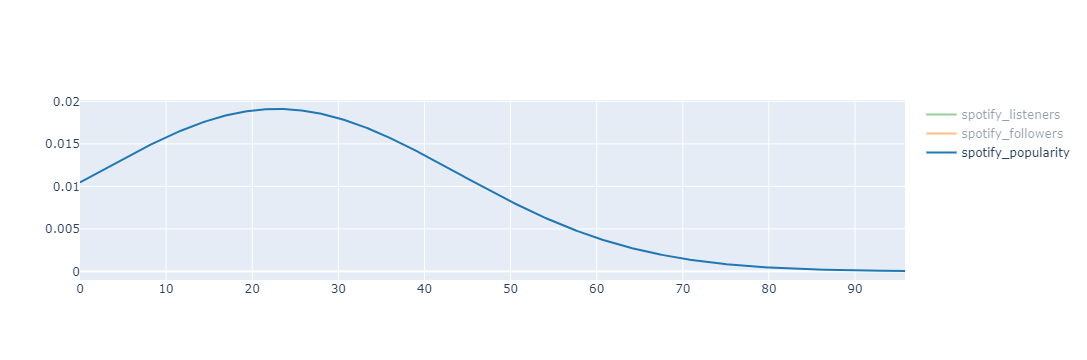

In [136]:
distri_data = [x for x in stats_array.T]
distri_label = [label for label in artists_matched_stats_df.columns]

fig = ff.create_distplot(
    distri_data,
    distri_label,
    curve_type='normal',  # override default 'kde'
    show_hist=False,
    show_rug=False,
)
fig.show()

## Individual artist stats
---

### Get tour and mobility stats for each artist

In [16]:
concerts_df = concerts_df.set_index('concert_id')
full_data_df

,venue_id,concert_id,artist_id,spotify_genre,top_genre
0,/venues/1943879,/festivals/3267425,/artists/10069604-flavio-stonex,NaN,NaN
1,/venues/1943879,/festivals/3250138,/artists/10069604-flavio-stonex,NaN,NaN
2,/venues/4353777,/festivals/3262463,/artists/10069604-flavio-stonex,NaN,NaN
3,/venues/4353777,/festivals/3243521,/artists/10069604-flavio-stonex,NaN,NaN
4,/venues/4353777,/festivals/3252459,/artists/10069604-flavio-stonex,NaN,NaN
...,...,...,...,...,...
319125,/venues/1129971,/concerts/14836239,/artists/591687-abandon-all-ships,trancecore,dance music
319126,/venues/1129971,/concerts/14836239,/artists/591687-abandon-all-ships,canadian post-hardcore,experimental music
319127,/venues/1129971,/concerts/14836239,/artists/591687-abandon-all-ships,canadian post-hardcore,rock music
319128,/venues/1129971,/concerts/14836239,/artists/591687-abandon-all-ships,canadian post-hardcore,dance music


In [17]:
artist_id_list = list(full_data_df['artist_id'].unique())
print(len(artist_id_list))
artist_id_list[:10]

24719


['/artists/10069604-flavio-stonex',
 '/artists/11032-jazz-connection',
 '/artists/2865626-james-lann',
 '/artists/8496013-trummer-ch',
 '/artists/8498548-vincent-vegas-last-dance',
 '/artists/951712-james-gruntz',
 '/artists/761499-da-cruz',
 '/artists/9723809-sanic-production',
 '/artists/3612061-manolo-panic',
 '/artists/873057-sherlock-brothers']

In [34]:
id_1 = '/artists/334588-autumn'
id_2 = '/artists/469292-rebekah'
id_3 = '/artists/448853-midnight-juggernauts'
id_4 = '/artists/6728344-coely'

artist_data_df = full_data_df.loc[full_data_df['artist_id'] == '/artists/10069604-flavio-stonex']
artist_data_df = full_data_df.loc[full_data_df['artist_id'] == id_4]
artist_data_df = artist_data_df.merge(concerts_df['date'], left_on='concert_id', right_index=True)
artist_data_df = artist_data_df.merge(venues_df[['venue_id', 'latitude', 'longitude', 'venue']], on='venue_id')
artist_data_df.sort_values(by=['date', 'latitude'])

,venue_id,concert_id,artist_id,spotify_genre,top_genre,date,latitude,longitude,venue
0,/venues/492141,/concerts/25244819,/artists/6728344-coely,belgian hip hop,world music,2015-11-12,46.1831,6.10054,Salle Communale
1,/venues/492141,/concerts/25244819,/artists/6728344-coely,belgian hip hop,hip hop music,2015-11-12,46.1831,6.10054,Salle Communale
2,/venues/1004201,/concerts/38067614,/artists/6728344-coely,belgian hip hop,world music,2019-07-16,47.4286,9.38296,"Innenhof, Historisches und Völkerkundemuseum"
3,/venues/1004201,/concerts/38067614,/artists/6728344-coely,belgian hip hop,hip hop music,2019-07-16,47.4286,9.38296,"Innenhof, Historisches und Völkerkundemuseum"


In [20]:
def format_date(date):
    date_formatted = datetime.strptime(date, '%Y-%m-%d')
    
    return date_formatted

def get_concert_frequency(date_in, date_out):
    days_between_dates = (format_date(date_out) - format_date(date_in)).days
    concert_frequency = days_between_dates / nbr_concerts
    return concert_frequency

def get_days_between_dates(date_in, date_out):
    days_between_dates = (format_date(date_out) - format_date(date_in)).days + 1  # add one to count 3 days between 10.02 and 12.02
    return days_between_dates

def get_tours(artist_data_df):
    concert_count = 0
    total_count = 0
    nbr_tours = 0
    total_tour_concerts = 0
    total_tour_days = 0
    avg_tour_days = 0
    avg_tour_concerts = 0
    
    dates_list = sorted(artist_data_df['date'].unique())
    first_tour_date = dates_list[0]
    
    for i in range(len(dates_list)):
        concert_count += 1
        total_count += 1
        #print(dates_list[i])
        if i < len(dates_list) - 1:    
            days_between_dates = get_days_between_dates(dates_list[i], dates_list[i+1])
            
            # if there is a 90-day gap between two dates. 90 = threshold to consider end of a tour (avoiding summer break of roughly 3 months)
            if days_between_dates > 90:
                #print('---', days_between_dates, '--', dates_list[i], dates_list[i+1])
                #print(concert_count)
                
                # a tour is considered when concert streak is at least 2
                if concert_count > 1:
                    last_tour_date = dates_list[i]
                    days_in_tour = get_days_between_dates(first_tour_date, last_tour_date)
                    #print(days_in_tour)
                    total_tour_days += days_in_tour
                    total_tour_concerts += concert_count
                    nbr_tours += 1
                
                first_tour_date = dates_list[i+1]
                concert_count = 0
                #print('--------------------')
                
            else:
                #print(days_between_dates, '--', dates_list[i], dates_list[i+1])
                pass
        else:
            if concert_count > 1:
                last_tour_date = dates_list[i]
                days_in_tour = get_days_between_dates(first_tour_date, last_tour_date)
                #print(days_in_tour)
                total_tour_days += days_in_tour
                total_tour_concerts += concert_count
                nbr_tours += 1

    #print(concert_count)
    #print(total_count)
    if nbr_tours > 0:
        avg_tour_concerts = total_tour_concerts / nbr_tours
        avg_tour_days = total_tour_days / nbr_tours
        
    return nbr_tours, avg_tour_concerts, avg_tour_days

get_tours(artist_data_df)

(1, 8.0, 85.0)

In [21]:
get_days_between_dates('2010-01-01', '2019-12-31')

3652

In [22]:
def get_genres_by_artist(genre_type, artist_data_df):    
    genres_by_artist = list(artist_data_df[genre_type].unique())

    try:
        genres_by_artist.remove(np.nan)
    except ValueError:
        pass
    
    return genres_by_artist

In [23]:
def get_first_last_concert_dates(artist_data_df):
    concert_date_set = set()

    for idx, row in artist_data_df.iterrows():
        concert_date = row['date'] 
        concert_date_set.add(concert_date)

    first_concert_date = min(concert_date_set)
    last_concert_date = max(concert_date_set)
    
    return first_concert_date, last_concert_date

In [35]:
def get_distance(artist_data_df):
    distance_centroid_total = 0
    distance_centroid_mean = 0
    distance_centroid_median = 0
    distance_centroid_list = list()
    concerts_counter = 0  # count the concerts with geo coordinates
    
    # keep single row for each concert
    lat_list = list(artist_data_df['latitude'])
    lon_list = list(artist_data_df['longitude'])
    coord_list = list()
    
    # calculate centroid of coordinates
    for i in range(len(lat_list)):
        lat = lat_list[i]
        lon = lon_list[i]

        if pd.notna(lat):
            coord_list.append((lat, lon))
    
    #print(coord_list)
    centroid = np.mean(coord_list, axis=0)
    
    try:
        centroid_lat = centroid[0]
        centroid_lon = centroid[1]
        
        for coord in coord_list:
            if pd.notna(coord[0]):
                distance_centroid = (distance.distance(centroid, coord)).km
                distance_centroid_total += distance_centroid
                distance_centroid_list.append(distance_centroid)  # for median
                concerts_counter +=1

        # mean and median distance between all concerts and centroid
        if concerts_counter > 0:
            #print(concerts_counter)
            distance_centroid_mean = distance_centroid_total / concerts_counter
            distance_centroid_median = statistics.median(distance_centroid_list)
            
    except IndexError:
        centroid_lat = np.nan
        centroid_lon = np.nan
    
    return centroid_lat, centroid_lon, distance_centroid_total, distance_centroid_mean, distance_centroid_median

get_distance(artist_data_df)

(46.80585000000001,
 7.741750000000001,
 572.5033000016983,
 143.12582500042458,
 143.12582500042458)

In [26]:
# NB: plusieurs concert_id font référence au même concert (erreur de songkick)
# ex. /concerts/25629229 et /concerts/24815429
# => utiliser nombre de dates uniques pour avoir le nombre de concerts par un artiste (présuppose qu'un artiste ne fait pas 2 concerts par jour)

artist_stats_dict = dict()

for artist_id in tqdm(artist_id_list[:]):
    artist_stats_dict[artist_id] = dict()
    artist_data_df = full_data_df.loc[full_data_df['artist_id'] == artist_id]
    artist_data_df = artist_data_df.merge(concerts_df['date'], left_on='concert_id', right_index=True)
    artist_data_df = artist_data_df.merge(venues_df[['venue_id', 'latitude', 'longitude']], on='venue_id')
    
    # if artist plays multiple times on a same day, drop concerts happening at same date and same place
    unique_concerts_df = artist_data_df.drop_duplicates(['date', 'latitude'], keep='first')
    
    nbr_venues = len(artist_data_df['venue_id'].unique())
    artist_stats_dict[artist_id]['nbr_venues'] = nbr_venues

    nbr_concerts = len(artist_data_df['date'].unique())
    artist_stats_dict[artist_id]['nbr_concerts'] = nbr_concerts

    # if some concerts are on the same day (songkick error mostly), there can be more venues than concerts
    # solution is to set the nbr of concerts to 
    if nbr_venues > nbr_concerts:
        nbr_concerts = len(unique_concerts_df)
        artist_stats_dict[artist_id]['nbr_concerts'] = nbr_concerts
    
    top_genres_by_artist = get_genres_by_artist('top_genre', artist_data_df)
    artist_stats_dict[artist_id]['top_genres'] = top_genres_by_artist
    
    spotify_genres_by_artist = get_genres_by_artist('spotify_genre', artist_data_df)
    artist_stats_dict[artist_id]['spotify_genres'] = spotify_genres_by_artist
    
    first_concert_date, last_concert_date = get_first_last_concert_dates(unique_concerts_df)
    artist_stats_dict[artist_id]['first_concert_date'] = first_concert_date
    artist_stats_dict[artist_id]['last_concert_date'] = last_concert_date
    
    active_days = get_days_between_dates(first_concert_date, last_concert_date)
    active_days_weighted = active_days / 3652  # 3652 is the number of days between 2010 and 2019
    if active_days > 0:
        concert_frequency = nbr_concerts / active_days
    else:
        concert_frequency = 0
    artist_stats_dict[artist_id]['active_days'] = active_days
    artist_stats_dict[artist_id]['active_days_weighted'] = round(active_days_weighted, 4)
    artist_stats_dict[artist_id]['concert_frequency'] = round(concert_frequency, 4)
    
    nbr_tours, avg_tour_concerts, avg_tour_days = get_tours(unique_concerts_df)
    if avg_tour_days > 0:
        tour_concert_frequency = avg_tour_concerts / avg_tour_days
    else: 
        tour_concert_frequency = 0
    artist_stats_dict[artist_id]['nbr_tours'] = nbr_tours
    artist_stats_dict[artist_id]['avg_tour_concerts'] = round(avg_tour_concerts, 2)
    artist_stats_dict[artist_id]['avg_tour_days'] = round(avg_tour_days, 2)
    artist_stats_dict[artist_id]['tour_concert_frequency'] = round(tour_concert_frequency, 2)
    
    centroid_lat, centroid_lon, dist_centroid_total, dist_centroid_mean, dist_centroid_median = get_distance(unique_concerts_df)
    artist_stats_dict[artist_id]['centroid_lat'] = centroid_lat
    artist_stats_dict[artist_id]['centroid_lon'] = centroid_lon
    artist_stats_dict[artist_id]['dist_centroid_total'] = round(dist_centroid_total, 1)
    artist_stats_dict[artist_id]['dist_centroid_mean'] = round(dist_centroid_mean, 1)
    #artist_stats_dict[artist_id]['dist_centroid_median'] = round(dist_centroid_median, 1)
    
    mobility = nbr_venues / nbr_concerts
    artist_stats_dict[artist_id]['mobility'] = round(mobility, 4)
    
    mobility_weighted_mean = dist_centroid_mean * mobility / 175
    artist_stats_dict[artist_id]['mobility_weighted_mean'] = round(mobility_weighted_mean, 4)
    
    mobility_weighted_median = dist_centroid_median * mobility / 175
    #artist_stats_dict[artist_id]['mobility_weighted_median'] = round(mobility_weighted_median, 3)
    
artist_stats_df = pd.DataFrame.from_dict(artist_stats_dict, orient='index')
artist_stats_df

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24719/24719 [22:54<00:00, 17.98it/s]


,nbr_venues,nbr_concerts,top_genres,spotify_genres,first_concert_date,last_concert_date,active_days,active_days_weighted,concert_frequency,nbr_tours,avg_tour_concerts,avg_tour_days,tour_concert_frequency,centroid_lat,centroid_lon,dist_centroid_total,dist_centroid_mean,mobility,mobility_weighted_mean
/artists/10069604-flavio-stonex,5,8,[],[],2019-09-14,2019-12-07,85,0.0233,0.0941,1,8.0,85.00,0.09,47.125451,9.113339,312.7,39.1,0.6250,0.1396
/artists/11032-jazz-connection,3,4,[],[],2016-11-11,2018-08-11,639,0.1750,0.0063,2,2.0,9.00,0.22,47.223530,8.988170,157.3,39.3,0.7500,0.1685
/artists/2865626-james-lann,2,2,"[world music, country music]",[texas country],2012-08-08,2012-08-10,3,0.0008,0.6667,1,2.0,3.00,0.67,47.298935,8.502708,150.5,75.2,1.0000,0.4299
/artists/8496013-trummer-ch,69,77,[],[],2015-04-25,2019-12-20,1701,0.4658,0.0453,4,19.0,316.25,0.06,47.014086,7.891114,3524.6,45.8,0.8961,0.2344
/artists/8498548-vincent-vegas-last-dance,2,2,[],[],2015-07-10,2015-10-03,86,0.0235,0.0233,1,2.0,86.00,0.02,46.750970,7.601075,51.9,26.0,1.0000,0.1483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/artists/5592793-earl-sweatshirt,1,1,"[world music, hip hop music, experimental musi...","[alternative hip hop, experimental hip hop, ra...",2014-03-18,2014-03-18,1,0.0003,1.0000,0,0.0,0.00,0.00,47.387320,8.499860,0.0,0.0,1.0000,0.0000
/artists/2699691-we-are-the-in-crowd,1,1,"[rock music, pop music, experimental music]","[pixie, pop punk, candy pop, pop emo, neon pop...",2013-04-29,2013-04-29,1,0.0003,1.0000,0,0.0,0.00,0.00,47.387320,8.499860,0.0,0.0,1.0000,0.0000
/artists/2338458-never-shout-never,1,1,"[pop music, rock music, experimental music]","[pop punk, pop emo, neon pop punk, alternative...",2013-04-29,2013-04-29,1,0.0003,1.0000,0,0.0,0.00,0.00,47.387320,8.499860,0.0,0.0,1.0000,0.0000
/artists/295364-propagandhi,1,1,"[rock music, folk music, world music]","[folk punk, canadian punk, skate punk, punk, m...",2013-04-24,2013-04-24,1,0.0003,1.0000,0,0.0,0.00,0.00,47.387320,8.499860,0.0,0.0,1.0000,0.0000


In [47]:
mobility_max = artist_stats_df['mobility_weighted_mean'].max()
artist_stats_df['mobility_weighted'] = artist_stats_df['mobility_weighted_mean'] / mobility_max
artist_stats_df.sort_values(by=['mobility_weighted'])

,nbr_venues,nbr_concerts,top_genres,spotify_genres,first_concert_date,last_concert_date,active_days,active_days_weighted,concert_frequency,nbr_tours,avg_tour_concerts,avg_tour_days,tour_concert_frequency,centroid_lat,centroid_lon,dist_centroid_total,dist_centroid_mean,mobility,mobility_weighted_mean,mobility_weighted
/artists/591687-abandon-all-ships,1,1,"[rock music, experimental music, electronic mu...","[canadian metalcore, metalcore, post-screamo, ...",2013-04-09,2013-04-09,1,0.0003,1.0000,0,0.0,0.0,0.00,47.387320,8.499860,0.0,0.0,1.0000,0.0000,0.000000
/artists/6896329-kahn-and-neek,1,1,[],[],2013-10-04,2013-10-04,1,0.0003,1.0000,0,0.0,0.0,0.00,47.136720,7.252010,0.0,0.0,1.0000,0.0000,0.000000
/artists/557284-robert-hood,1,2,"[electronic music, dance music, world music, e...","[outsider house, electro, deep house, dub tech...",2011-06-17,2012-12-07,540,0.1479,0.0037,0,0.0,0.0,0.00,46.520670,6.631550,0.0,0.0,0.5000,0.0000,0.000000
/artists/5100428-victory-riders,1,2,[],[],2012-05-26,2012-11-23,182,0.0498,0.0110,0,0.0,0.0,0.00,46.520670,6.631550,0.0,0.0,0.5000,0.0000,0.000000
/artists/5841309-nom-nom,1,3,[],[],2012-09-07,2012-11-24,79,0.0216,0.0380,1,3.0,79.0,0.04,46.520670,6.631550,0.0,0.0,0.3333,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/artists/775326-willie-evans-jr,2,2,[],[],2012-05-12,2012-05-13,2,0.0005,1.0000,1,2.0,2.0,1.00,46.815310,7.754725,281.9,141.0,1.0000,0.8056,0.984961
/artists/3341191-wolves-like-us,2,2,[],[],2011-07-26,2014-04-15,995,0.2725,0.0020,0,0.0,0.0,0.00,46.815660,7.755220,282.0,141.0,1.0000,0.8058,0.985206
/artists/435177-gories,2,2,"[rock music, pop music]","[garage rock, punk blues, detroit rock, garage...",2015-05-24,2015-05-27,4,0.0011,0.5000,1,2.0,4.0,0.50,46.812015,7.751620,282.7,141.4,1.0000,0.8078,0.987651
/artists/481090-move-d,2,2,"[electronic music, dance music, world music, s...","[outsider house, deep house, german house, dub...",2013-10-31,2015-09-09,679,0.1859,0.0029,0,0.0,0.0,0.00,46.812365,7.752115,282.8,141.4,1.0000,0.8081,0.988018


In [48]:
artist_stats_df.to_csv('data/data_stats_artists.csv', encoding='utf-8')

### Add audio features stats

In [49]:
with open('data/spotify/data_spotify_tracks_no_duplicate.csv', encoding='utf-8') as file:
    tracks_df = pd.read_csv(file, index_col=0)
    
with open('data/data_stats_artists.csv', encoding='utf-8') as file:
    artist_stats_df = pd.read_csv(file, index_col=0)
    
with open('data/spotify/data_spotify_artists_light.csv', encoding='utf-8') as file:
    artists_df = pd.read_csv(file, index_col=0).set_index('artist_id')[['spotify_followers', 'spotify_listeners']]
    
artists_df

,spotify_followers,spotify_listeners
artist_id,,
/artists/3684861-chk-chk-chk,135100.0,305800.0
/artists/694091-kadebostan,1348.0,2000.0
/artists/5929284-brothers-in-bamako,NaN,NaN
/artists/8704378-floyd-division-the-austrian-pink-floyd-tribute-band,NaN,NaN
/artists/7172094-jazzetcetera-stewy-von-wattenwyl-group-feat-lisette-spinnler,NaN,NaN
...,...,...
/artists/4301-and-you-will-know-us-by-the-trail-of-dead,64802.0,99200.0
/artists/1099500-euuroshima,14600.0,79300.0
/artists/9573874-belize-it,6697.0,4900.0


In [50]:
# drop columns of features not useful

useless_features = ['track_popularity', 'key', 'mode', 'time_signature']
tracks_df = tracks_df.drop(columns=useless_features)
tracks_df

,track_name,spotify_name,spotify_id,artist_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
track_id,,,,,,,,,,,,,,
20a7nkw3Mj8C2iVQBgz10X,Cells,Motion Drive,0001wHqxbF2YYRQxGdbyER,/artists/1179216-motion-drive,0.608,0.728,-6.014,0.0365,0.000345,0.865,0.0741,0.153,131.992,480000.0
2jXv1eQoORVq2jPITROvMQ,Dualdrive,Motion Drive,0001wHqxbF2YYRQxGdbyER,/artists/1179216-motion-drive,0.763,0.855,-6.025,0.0388,0.000922,0.815,0.3370,0.524,132.018,496280.0
37XyXRMsEHwA7Fz9020VF6,Puppetmaster,Motion Drive,0001wHqxbF2YYRQxGdbyER,/artists/1179216-motion-drive,0.635,0.742,-7.738,0.0391,0.005000,0.830,0.2870,0.278,132.999,569642.0
3n4Gc2ES7UwvbJ3lh5QVnV,Thrilled Version 2,Motion Drive,0001wHqxbF2YYRQxGdbyER,/artists/1179216-motion-drive,0.598,0.845,-7.926,0.0433,0.001190,0.797,0.5670,0.410,131.985,476320.0
5nn11m2aCK3jbqh0xQKQd2,Jessica Lee - Motion Drive Remix,Motion Drive,0001wHqxbF2YYRQxGdbyER,/artists/1179216-motion-drive,0.607,0.770,-10.538,0.0547,0.009180,0.818,0.1520,0.106,133.013,546505.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5YJkBqBKcHBpIUDsar0RCE,Bahamas - Daniel Meister Remix,Daniel Meister,7zyqPpoCgfy4KZaqnMY70O,/artists/5389813-daniel-meister,0.812,0.827,-10.803,0.0689,0.000755,0.885,0.0586,0.803,122.016,410000.0
69aGh9vBSKKWlpki8z0jl2,Mo,Daniel Meister,7zyqPpoCgfy4KZaqnMY70O,/artists/5389813-daniel-meister,0.798,0.853,-11.975,0.0784,0.007760,0.937,0.0898,0.450,129.014,239070.0
6LojCeyuhDloizAjPdWRLx,Our Space - Daniel Meister Remix,Daniel Meister,7zyqPpoCgfy4KZaqnMY70O,/artists/5389813-daniel-meister,0.810,0.852,-9.007,0.0603,0.000095,0.951,0.0490,0.669,127.993,363438.0


In [51]:
artists_features = tracks_df.groupby('artist_id').mean()
artist_stats_features_df = artist_stats_df.merge(artists_features, how='left', left_index=True, right_index=True)
# add listeners and followers stats
artist_stats_features_df = artist_stats_features_df.merge(artists_df, how='left', left_index=True, right_index=True)
artist_stats_features_df

,nbr_venues,nbr_concerts,top_genres,spotify_genres,first_concert_date,last_concert_date,active_days,active_days_weighted,concert_frequency,nbr_tours,...,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,spotify_followers,spotify_listeners
/artists/10069604-flavio-stonex,5,8,[],[],2019-09-14,2019-12-07,85,0.0233,0.0941,1,...,-6.734889,0.059500,0.017928,3.138071e-01,0.270722,0.188178,129.355111,185672.222222,273.0,298.0
/artists/11032-jazz-connection,3,4,[],[],2016-11-11,2018-08-11,639,0.1750,0.0063,2,...,-12.038500,0.043710,0.417144,5.608000e-01,0.127100,0.411480,123.896300,270747.300000,287.0,3300.0
/artists/2865626-james-lann,2,2,"['world music', 'country music']",['texas country'],2012-08-08,2012-08-10,3,0.0008,0.6667,1,...,-6.829800,0.035230,0.113219,3.890000e-06,0.242200,0.530000,119.826300,210181.400000,2832.0,2800.0
/artists/8496013-trummer-ch,69,77,[],[],2015-04-25,2019-12-20,1701,0.4658,0.0453,4,...,-17.426800,0.075560,0.537670,8.836000e-01,0.135250,0.204320,103.248800,426677.200000,138.0,1700.0
/artists/8498548-vincent-vegas-last-dance,2,2,[],[],2015-07-10,2015-10-03,86,0.0235,0.0233,1,...,-8.088300,0.036190,0.093387,2.234647e-01,0.215420,0.300820,117.143000,294387.200000,38.0,410.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/artists/5592793-earl-sweatshirt,1,1,"['world music', 'hip hop music', 'experimental...","['alternative hip hop', 'experimental hip hop'...",2014-03-18,2014-03-18,1,0.0003,1.0000,0,...,-5.833700,0.271240,0.209620,3.490162e-02,0.358100,0.592700,127.013400,189189.700000,1588790.0,2900000.0
/artists/2699691-we-are-the-in-crowd,1,1,"['rock music', 'pop music', 'experimental music']","['pixie', 'pop punk', 'candy pop', 'pop emo', ...",2013-04-29,2013-04-29,1,0.0003,1.0000,0,...,-5.056100,0.095450,0.019808,0.000000e+00,0.147630,0.591700,156.753400,188237.800000,174869.0,220400.0
/artists/2338458-never-shout-never,1,1,"['pop music', 'rock music', 'experimental music']","['pop punk', 'pop emo', 'neon pop punk', 'alte...",2013-04-29,2013-04-29,1,0.0003,1.0000,0,...,-6.965100,0.108900,0.498920,3.610000e-07,0.208130,0.556400,107.266900,164591.200000,559407.0,650500.0
/artists/295364-propagandhi,1,1,"['rock music', 'folk music', 'world music']","['folk punk', 'canadian punk', 'skate punk', '...",2013-04-24,2013-04-24,1,0.0003,1.0000,0,...,-5.155900,0.084620,0.004794,2.422649e-03,0.323310,0.555300,125.837600,169032.000000,145115.0,185800.0


In [52]:
nbr_artists_with_features = artist_stats_features_df['tempo'].count()
total_artists_with_stats = len(artist_stats_features_df)
print('Nbr artists with audio features:', nbr_artists_with_features)
print('Nbr artists without features:', total_artists_with_stats - nbr_artists_with_features)
print('Total artists with stats:', total_artists_with_stats)

Nbr artists with audio features: 24051
Nbr artists without features: 668
Total artists with stats: 24719


In [53]:
artist_stats_features_df.count()

nbr_venues                24719
nbr_concerts              24719
top_genres                24719
spotify_genres            24719
first_concert_date        24719
last_concert_date         24719
active_days               24719
active_days_weighted      24719
concert_frequency         24719
nbr_tours                 24719
avg_tour_concerts         24719
avg_tour_days             24719
tour_concert_frequency    24719
centroid_lat              24719
centroid_lon              24719
dist_centroid_total       24719
dist_centroid_mean        24719
mobility                  24719
mobility_weighted_mean    24719
mobility_weighted         24719
danceability              24051
energy                    24051
loudness                  24051
speechiness               24051
acousticness              24051
instrumentalness          24051
liveness                  24051
valence                   24051
tempo                     24051
duration_ms               24051
spotify_followers         24719
spotify_

In [54]:
artist_stats_features_df.to_csv('data/data_stats_artists_features.csv', encoding='utf-8')

## Venues stats
---

In [58]:
with open('data/full_data.csv', encoding='utf-8') as file:
    full_data_df = pd.read_csv(file).drop(columns=['Unnamed: 0'])
    
with open('data/songkick/data_songkick_venues_light_coord.csv', encoding='utf-8') as file:
    venues_df = pd.read_csv(file, index_col=0)
    
with open('data/data_stats_artists_features.csv', encoding='utf-8') as file:
    artists_stats_features_df = pd.read_csv(file, index_col=0)

artists_stats_features_df

,nbr_venues,nbr_concerts,top_genres,spotify_genres,first_concert_date,last_concert_date,active_days,active_days_weighted,concert_frequency,nbr_tours,...,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,spotify_followers,spotify_listeners
/artists/10069604-flavio-stonex,5,8,[],[],2019-09-14,2019-12-07,85,0.0233,0.0941,1,...,-6.734889,0.059500,0.017928,3.138071e-01,0.270722,0.188178,129.355111,185672.222222,273.0,298.0
/artists/11032-jazz-connection,3,4,[],[],2016-11-11,2018-08-11,639,0.1750,0.0063,2,...,-12.038500,0.043710,0.417144,5.608000e-01,0.127100,0.411480,123.896300,270747.300000,287.0,3300.0
/artists/2865626-james-lann,2,2,"['world music', 'country music']",['texas country'],2012-08-08,2012-08-10,3,0.0008,0.6667,1,...,-6.829800,0.035230,0.113219,3.890000e-06,0.242200,0.530000,119.826300,210181.400000,2832.0,2800.0
/artists/8496013-trummer-ch,69,77,[],[],2015-04-25,2019-12-20,1701,0.4658,0.0453,4,...,-17.426800,0.075560,0.537670,8.836000e-01,0.135250,0.204320,103.248800,426677.200000,138.0,1700.0
/artists/8498548-vincent-vegas-last-dance,2,2,[],[],2015-07-10,2015-10-03,86,0.0235,0.0233,1,...,-8.088300,0.036190,0.093387,2.234647e-01,0.215420,0.300820,117.143000,294387.200000,38.0,410.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/artists/5592793-earl-sweatshirt,1,1,"['world music', 'hip hop music', 'experimental...","['alternative hip hop', 'experimental hip hop'...",2014-03-18,2014-03-18,1,0.0003,1.0000,0,...,-5.833700,0.271240,0.209620,3.490162e-02,0.358100,0.592700,127.013400,189189.700000,1588790.0,2900000.0
/artists/2699691-we-are-the-in-crowd,1,1,"['rock music', 'pop music', 'experimental music']","['pixie', 'pop punk', 'candy pop', 'pop emo', ...",2013-04-29,2013-04-29,1,0.0003,1.0000,0,...,-5.056100,0.095450,0.019808,0.000000e+00,0.147630,0.591700,156.753400,188237.800000,174869.0,220400.0
/artists/2338458-never-shout-never,1,1,"['pop music', 'rock music', 'experimental music']","['pop punk', 'pop emo', 'neon pop punk', 'alte...",2013-04-29,2013-04-29,1,0.0003,1.0000,0,...,-6.965100,0.108900,0.498920,3.610000e-07,0.208130,0.556400,107.266900,164591.200000,559407.0,650500.0
/artists/295364-propagandhi,1,1,"['rock music', 'folk music', 'world music']","['folk punk', 'canadian punk', 'skate punk', '...",2013-04-24,2013-04-24,1,0.0003,1.0000,0,...,-5.155900,0.084620,0.004794,2.422649e-03,0.323310,0.555300,125.837600,169032.000000,145115.0,185800.0


In [59]:
artists_stats_features_df['mobility_weighted']

/artists/10069604-flavio-stonex              0.170681
/artists/11032-jazz-connection               0.206015
/artists/2865626-james-lann                  0.525614
/artists/8496013-trummer-ch                  0.286588
/artists/8498548-vincent-vegas-last-dance    0.181318
                                               ...   
/artists/5592793-earl-sweatshirt             0.000000
/artists/2699691-we-are-the-in-crowd         0.000000
/artists/2338458-never-shout-never           0.000000
/artists/295364-propagandhi                  0.000000
/artists/591687-abandon-all-ships            0.000000
Name: mobility_weighted, Length: 24719, dtype: float64

In [60]:
full_data_df.nunique()

venue_id          5063
concert_id       62827
artist_id        24719
spotify_genre     3649
top_genre           23
dtype: int64

In [61]:
venues_df.nunique()

venue_id           7657
linked_venue_id    7224
venue              7352
locality            161
latitude           4054
longitude          4136
auto_coord            1
dtype: int64

In [62]:
venues_df.count()

venue_id           7657
linked_venue_id    7657
venue              7657
locality           7657
latitude           7657
longitude          7657
auto_coord         2326
dtype: int64

### Genre stats in venues

In [63]:
venues_stats_genres = full_data_df.groupby(['venue_id', 'top_genre'])['concert_id'].nunique().unstack(fill_value=0).rename_axis(None, axis="columns")
venues_stats_genres

,acoustic music,art music,blues,children's music,country music,dance music,electronic music,experimental music,folk music,functional music,...,instrumental music,jazz,lo-fi music,pop music,rhythm and blues,rock music,soul music,underground music,vocal music,world music
venue_id,,,,,,,,,,,,,,,,,,,,,
/venues/1002631,0,2,0,0,0,2,0,0,0,0,...,0,0,0,2,2,0,0,0,0,2
/venues/1004201,4,13,12,0,12,14,17,0,20,1,...,0,4,0,22,0,22,0,0,3,27
/venues/1004876,0,0,0,0,0,0,0,0,2,10,...,0,2,0,2,0,5,0,0,0,6
/venues/1006731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
/venues/100720,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/venues/98757,11,13,5,0,9,4,8,1,76,4,...,4,13,0,91,3,36,2,0,20,101
/venues/988536,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
/venues/993251,0,0,1,0,0,0,0,0,1,0,...,0,1,0,1,1,0,0,0,0,5


In [64]:
def simpson_diversity(n):
    N = n.sum()
    nn_1 = sum(n * (n - 1))
    score = 1 - (nn_1 / (N * (N - 1) ) )
    
    return score

In [65]:
diversity_df = pd.DataFrame()

for idx, row in venues_stats_genres.iterrows():
    diversity = simpson_diversity(row).round(2)
    diversity_df.loc[idx, 'genre_diversity'] = diversity
    
diversity_df

C:\Users\Cyrille\AppData\Local\Temp/ipykernel_17900/1058292032.py:4: RuntimeWarning: invalid value encountered in longlong_scalars
  score = 1 - (nn_1 / (N * (N - 1) ) )


,genre_diversity
/venues/1002631,0.91
/venues/1004201,0.92
/venues/1004876,0.84
/venues/1006731,NaN
/venues/100720,0.81
...,...
/venues/98757,0.84
/venues/988536,1.00
/venues/993251,0.82
/venues/996001,1.00


<AxesSubplot:>

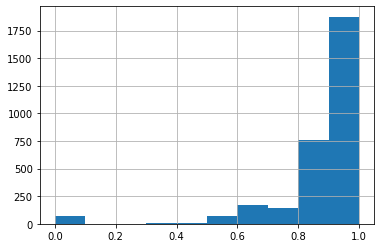

In [66]:
diversity_df['genre_diversity'].hist(bins=10)

In [67]:
venues_idx = venues_stats_genres.index
venues_concerts_sum = full_data_df.loc[full_data_df['venue_id'].isin(venues_idx)].groupby('venue_id')['concert_id'].nunique()
venues_concerts_sum

venue_id
/venues/1002631      2
/venues/1004201     40
/venues/1004876     34
/venues/1006731      1
/venues/100720       3
                  ... 
/venues/98757      181
/venues/988536       2
/venues/993251       5
/venues/996001       2
/venues/996021       1
Name: concert_id, Length: 3519, dtype: int64

In [68]:
venues_stats_genres = venues_stats_genres.div(venues_concerts_sum, axis=0).round(2)
venues_stats_genres = venues_stats_genres.merge(diversity_df, left_index=True, right_index=True)
venues_stats_genres['nbr_concerts'] = venues_concerts_sum
venues_stats_genres

,acoustic music,art music,blues,children's music,country music,dance music,electronic music,experimental music,folk music,functional music,...,lo-fi music,pop music,rhythm and blues,rock music,soul music,underground music,vocal music,world music,genre_diversity,nbr_concerts
venue_id,,,,,,,,,,,,,,,,,,,,,
/venues/1002631,0.00,1.00,0.00,0.0,0.00,1.00,0.00,0.00,0.00,0.00,...,0.0,1.00,1.00,0.00,0.00,0.0,0.00,1.00,0.91,2
/venues/1004201,0.10,0.32,0.30,0.0,0.30,0.35,0.42,0.00,0.50,0.02,...,0.0,0.55,0.00,0.55,0.00,0.0,0.08,0.68,0.92,40
/venues/1004876,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.06,0.29,...,0.0,0.06,0.00,0.15,0.00,0.0,0.00,0.18,0.84,34
/venues/1006731,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.00,1.00,0.00,0.0,0.00,0.00,NaN,1
/venues/100720,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.33,0.00,0.33,0.00,0.0,0.00,1.00,0.81,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/venues/98757,0.06,0.07,0.03,0.0,0.05,0.02,0.04,0.01,0.42,0.02,...,0.0,0.50,0.02,0.20,0.01,0.0,0.11,0.56,0.84,181
/venues/988536,0.00,0.00,0.00,0.0,0.00,0.00,0.50,0.00,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.50,1.00,2
/venues/993251,0.00,0.00,0.20,0.0,0.00,0.00,0.00,0.00,0.20,0.00,...,0.0,0.20,0.20,0.00,0.00,0.0,0.00,1.00,0.82,5


### Feature stats in venues

In [69]:
features_columns = [
    'spotify_followers', 'spotify_listeners',
    'nbr_venues', 'nbr_concerts', 
    'active_days', 'active_days_weighted', 'concert_frequency', 
    'nbr_tours', 'avg_tour_concerts', 'avg_tour_days', 'tour_concert_frequency', 
    'centroid_lat', 'centroid_lon', 'dist_centroid_total', 'dist_centroid_mean', 
    'mobility', 'mobility_weighted', 
    'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
]

features_columns_reduced = [
    'spotify_followers', 'spotify_listeners',
    'active_days', 'concert_frequency', 'avg_tour_concerts',
    'centroid_lat', 'centroid_lon', 'mobility', 'mobility_weighted',
    'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
]
artists_stats_features_df = artists_stats_features_df[features_columns_reduced]
artists_stats_features_df

,spotify_followers,spotify_listeners,active_days,concert_frequency,avg_tour_concerts,centroid_lat,centroid_lon,mobility,mobility_weighted,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
/artists/10069604-flavio-stonex,273.0,298.0,85,0.0941,8.0,47.125451,9.113339,0.6250,0.170681,0.624000,0.826667,-6.734889,0.059500,0.017928,3.138071e-01,0.270722,0.188178,129.355111,185672.222222
/artists/11032-jazz-connection,287.0,3300.0,639,0.0063,2.0,47.223530,8.988170,0.7500,0.206015,0.558900,0.431590,-12.038500,0.043710,0.417144,5.608000e-01,0.127100,0.411480,123.896300,270747.300000
/artists/2865626-james-lann,2832.0,2800.0,3,0.6667,2.0,47.298935,8.502708,1.0000,0.525614,0.564100,0.723100,-6.829800,0.035230,0.113219,3.890000e-06,0.242200,0.530000,119.826300,210181.400000
/artists/8496013-trummer-ch,138.0,1700.0,1701,0.0453,19.0,47.014086,7.891114,0.8961,0.286588,0.585300,0.408000,-17.426800,0.075560,0.537670,8.836000e-01,0.135250,0.204320,103.248800,426677.200000
/artists/8498548-vincent-vegas-last-dance,38.0,410.0,86,0.0233,2.0,46.750970,7.601075,1.0000,0.181318,0.391300,0.582100,-8.088300,0.036190,0.093387,2.234647e-01,0.215420,0.300820,117.143000,294387.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/artists/5592793-earl-sweatshirt,1588790.0,2900000.0,1,1.0000,0.0,47.387320,8.499860,1.0000,0.000000,0.542500,0.654300,-5.833700,0.271240,0.209620,3.490162e-02,0.358100,0.592700,127.013400,189189.700000
/artists/2699691-we-are-the-in-crowd,174869.0,220400.0,1,1.0000,0.0,47.387320,8.499860,1.0000,0.000000,0.485200,0.862300,-5.056100,0.095450,0.019808,0.000000e+00,0.147630,0.591700,156.753400,188237.800000
/artists/2338458-never-shout-never,559407.0,650500.0,1,1.0000,0.0,47.387320,8.499860,1.0000,0.000000,0.719900,0.516900,-6.965100,0.108900,0.498920,3.610000e-07,0.208130,0.556400,107.266900,164591.200000
/artists/295364-propagandhi,145115.0,185800.0,1,1.0000,0.0,47.387320,8.499860,1.0000,0.000000,0.430100,0.881700,-5.155900,0.084620,0.004794,2.422649e-03,0.323310,0.555300,125.837600,169032.000000


In [70]:
full_data_features_df = full_data_df.merge(artists_stats_features_df, left_on='artist_id', right_index=True)
# add lat and lon of venue to compute distance to artist centroid
full_data_features_df = full_data_features_df.merge(venues_df[['venue_id', 'latitude', 'longitude']], left_on='venue_id', right_on='venue_id')    
full_data_features_df

,venue_id,concert_id,artist_id,spotify_genre,top_genre,spotify_followers,spotify_listeners,active_days,concert_frequency,avg_tour_concerts,...,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,latitude,longitude
0,/venues/1943879,/festivals/3267425,/artists/10069604-flavio-stonex,NaN,NaN,273.0,298.0,85,0.0941,8.0,...,-6.734889,0.05950,0.017928,0.313807,0.270722,0.188178,129.355111,185672.222222,47.04380,9.42400
1,/venues/1943879,/festivals/3250138,/artists/10069604-flavio-stonex,NaN,NaN,273.0,298.0,85,0.0941,8.0,...,-6.734889,0.05950,0.017928,0.313807,0.270722,0.188178,129.355111,185672.222222,47.04380,9.42400
2,/venues/1943879,/concerts/32335899,/artists/11032-jazz-connection,NaN,NaN,287.0,3300.0,639,0.0063,2.0,...,-12.038500,0.04371,0.417144,0.560800,0.127100,0.411480,123.896300,270747.300000,47.04380,9.42400
3,/venues/1943879,/concerts/32335884,/artists/11032-jazz-connection,NaN,NaN,287.0,3300.0,639,0.0063,2.0,...,-12.038500,0.04371,0.417144,0.560800,0.127100,0.411480,123.896300,270747.300000,47.04380,9.42400
4,/venues/1943879,/concerts/13429724,/artists/2865626-james-lann,texas country,world music,2832.0,2800.0,3,0.6667,2.0,...,-6.829800,0.03523,0.113219,0.000004,0.242200,0.530000,119.826300,210181.400000,47.04380,9.42400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311827,/venues/2848088,/concerts/22485123,/artists/8340968-oblium,NaN,NaN,242.0,172.0,1,1.0000,0.0,...,-11.175700,0.18384,0.069555,0.618500,0.274770,0.197030,144.828000,687876.900000,46.00651,8.95231
311828,/venues/3085534,/concerts/24772624,/artists/161929-thibaud-couturier,NaN,NaN,15.0,6.0,1,1.0000,0.0,...,-9.975500,0.06322,0.398000,0.010457,0.107400,0.568900,117.163100,215195.200000,46.76691,6.75594
311829,/venues/3822394,/concerts/33069884,/artists/9420539-mj30,rumba congolaise,world music,2676.0,537.0,1,1.0000,0.0,...,-6.893000,0.06806,0.550630,0.007507,0.232700,0.821700,124.498100,364654.700000,46.20327,6.13489
311830,/venues/2626963,/concerts/20445908,/artists/886867-phil-donkin,NaN,NaN,130.0,1300.0,1,1.0000,0.0,...,-12.245500,0.07031,0.635300,0.153082,0.100200,0.321720,121.664700,409025.200000,47.55730,8.89941


In [71]:
venues_stats_artists = full_data_features_df.drop_duplicates(subset=['venue_id', 'artist_id']).groupby('venue_id').mean()
venues_stats_artists['nbr_artists'] = full_data_df.groupby('venue_id')['artist_id'].nunique()

# round followers and listeners
venues_stats_artists[['spotify_followers', 'spotify_listeners']] = venues_stats_artists[['spotify_followers', 'spotify_listeners']].round(0)

# remove venues that do not have genre stats
venues_stats_artists = venues_stats_artists.loc[venues_stats_genres.index]

venues_stats_artists

,spotify_followers,spotify_listeners,active_days,concert_frequency,avg_tour_concerts,centroid_lat,centroid_lon,mobility,mobility_weighted,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,latitude,longitude,nbr_artists
venue_id,,,,,,,,,,,,,,,,,,,,,
/venues/1002631,6180634.0,7400000.0,966.000000,0.003100,0.000000,47.377560,8.535740,0.666700,0.002078,0.721700,...,0.087890,0.207723,0.000005,0.253210,0.400300,100.992200,205716.900000,47.37861,8.54000,1
/venues/1004201,116125.0,511273.0,1621.962963,0.157639,4.800741,47.266191,8.594631,0.737009,0.243809,0.603104,...,0.070091,0.331899,0.151137,0.182364,0.491067,122.975813,240138.321017,47.42860,9.38296,54
/venues/1004876,5194.0,23018.0,775.789474,0.312126,4.086842,47.229872,8.321190,0.818242,0.174394,0.609299,...,0.068244,0.538786,0.244253,0.154785,0.487132,119.585560,233163.626316,47.39533,8.62396,19
/venues/1006731,276566.0,1100000.0,3339.000000,0.005100,2.750000,47.127851,7.783694,0.588200,0.348576,0.488600,...,0.043980,0.066242,0.063277,0.153540,0.353900,123.209400,257992.700000,46.49519,6.25853,1
/venues/100720,2569.0,9119.0,1940.600000,0.027860,10.814000,47.132116,8.128229,0.847740,0.310111,0.739436,...,0.111317,0.154258,0.010029,0.145348,0.589973,116.658747,226649.015556,46.68614,7.85261,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/venues/98757,374812.0,895193.0,1197.013514,0.292064,1.825946,46.624593,7.017615,0.836298,0.318027,0.565346,...,0.065532,0.458837,0.117402,0.195073,0.515145,117.301633,239725.264634,46.21018,6.15088,148
/venues/988536,11006.0,84667.0,1258.666667,0.338467,7.000000,46.623639,6.941620,0.710133,0.119982,0.699733,...,0.131800,0.238140,0.437436,0.181650,0.486267,104.388044,198890.211111,46.43466,6.91002,3
/venues/993251,238218.0,540580.0,1638.800000,0.203260,1.834000,47.014401,7.919568,0.894240,0.464727,0.692478,...,0.078274,0.377004,0.176938,0.153100,0.620987,119.816240,311796.882222,47.49972,8.75000,5


In [72]:
artist_centroid_list = venues_stats_artists[['centroid_lat', 'centroid_lon']].values.tolist()
venue_coord_list = venues_stats_artists[['latitude', 'longitude']].values.tolist()
dist_to_artist_list = list()

for i in range(len(artist_centroid_list)):
    try:
        artist_centroid = artist_centroid_list[i]
        venue_coord = venue_coord_list[i]
        dist_to_artist = (distance.distance(artist_centroid,  venue_coord)).km
        dist_to_artist_list.append(dist_to_artist)
    except ValueError:
        dist_to_artist_list.append(np.nan)
        
print(len(dist_to_artist_list))
venues_stats_artists['dist_to_artists_centroid'] = dist_to_artist_list
venues_stats_artists['dist_to_artists_centroid'] = venues_stats_artists['dist_to_artists_centroid'].round(2)
venues_stats_artists = venues_stats_artists.drop(columns=['latitude', 'longitude'])
venues_stats_artists

3519


,spotify_followers,spotify_listeners,active_days,concert_frequency,avg_tour_concerts,centroid_lat,centroid_lon,mobility,mobility_weighted,danceability,...,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,nbr_artists,dist_to_artists_centroid
venue_id,,,,,,,,,,,,,,,,,,,,,
/venues/1002631,6180634.0,7400000.0,966.000000,0.003100,0.000000,47.377560,8.535740,0.666700,0.002078,0.721700,...,-5.757900,0.087890,0.207723,0.000005,0.253210,0.400300,100.992200,205716.900000,1,0.34
/venues/1004201,116125.0,511273.0,1621.962963,0.157639,4.800741,47.266191,8.594631,0.737009,0.243809,0.603104,...,-8.698455,0.070091,0.331899,0.151137,0.182364,0.491067,122.975813,240138.321017,54,62.24
/venues/1004876,5194.0,23018.0,775.789474,0.312126,4.086842,47.229872,8.321190,0.818242,0.174394,0.609299,...,-11.266558,0.068244,0.538786,0.244253,0.154785,0.487132,119.585560,233163.626316,19,29.37
/venues/1006731,276566.0,1100000.0,3339.000000,0.005100,2.750000,47.127851,7.783694,0.588200,0.348576,0.488600,...,-7.387000,0.043980,0.066242,0.063277,0.153540,0.353900,123.209400,257992.700000,1,136.00
/venues/100720,2569.0,9119.0,1940.600000,0.027860,10.814000,47.132116,8.128229,0.847740,0.310111,0.739436,...,-7.241571,0.111317,0.154258,0.010029,0.145348,0.589973,116.658747,226649.015556,5,53.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/venues/98757,374812.0,895193.0,1197.013514,0.292064,1.825946,46.624593,7.017615,0.836298,0.318027,0.565346,...,-9.585425,0.065532,0.458837,0.117402,0.195073,0.515145,117.301633,239725.264634,148,81.01
/venues/988536,11006.0,84667.0,1258.666667,0.338467,7.000000,46.623639,6.941620,0.710133,0.119982,0.699733,...,-5.872333,0.131800,0.238140,0.437436,0.181650,0.486267,104.388044,198890.211111,3,21.15
/venues/993251,238218.0,540580.0,1638.800000,0.203260,1.834000,47.014401,7.919568,0.894240,0.464727,0.692478,...,-9.351884,0.078274,0.377004,0.176938,0.153100,0.620987,119.816240,311796.882222,5,82.84


In [73]:
rename_columns = {
    'active_days': 'artist_active_days',
    'avg_tour_concerts': 'artist_avg_tour_concerts',
    'concert_frequency': 'artist_concert_frequency',
    'centroid_lat': 'artist_centroid_lat',
    'centroid_lon': 'artist_centroid_lon',
    'mobility': 'artist_mobility',
    'mobility_weighted_mean': 'artist_mobility_weighted',
}

print(venues_stats_artists.columns)
venues_stats_artists = venues_stats_artists.rename(columns=rename_columns)
venues_stats_artists

Index(['spotify_followers', 'spotify_listeners', 'active_days',
       'concert_frequency', 'avg_tour_concerts', 'centroid_lat',
       'centroid_lon', 'mobility', 'mobility_weighted', 'danceability',
       'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'nbr_artists',
       'dist_to_artists_centroid'],
      dtype='object')


,spotify_followers,spotify_listeners,artist_active_days,artist_concert_frequency,artist_avg_tour_concerts,artist_centroid_lat,artist_centroid_lon,artist_mobility,mobility_weighted,danceability,...,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,nbr_artists,dist_to_artists_centroid
venue_id,,,,,,,,,,,,,,,,,,,,,
/venues/1002631,6180634.0,7400000.0,966.000000,0.003100,0.000000,47.377560,8.535740,0.666700,0.002078,0.721700,...,-5.757900,0.087890,0.207723,0.000005,0.253210,0.400300,100.992200,205716.900000,1,0.34
/venues/1004201,116125.0,511273.0,1621.962963,0.157639,4.800741,47.266191,8.594631,0.737009,0.243809,0.603104,...,-8.698455,0.070091,0.331899,0.151137,0.182364,0.491067,122.975813,240138.321017,54,62.24
/venues/1004876,5194.0,23018.0,775.789474,0.312126,4.086842,47.229872,8.321190,0.818242,0.174394,0.609299,...,-11.266558,0.068244,0.538786,0.244253,0.154785,0.487132,119.585560,233163.626316,19,29.37
/venues/1006731,276566.0,1100000.0,3339.000000,0.005100,2.750000,47.127851,7.783694,0.588200,0.348576,0.488600,...,-7.387000,0.043980,0.066242,0.063277,0.153540,0.353900,123.209400,257992.700000,1,136.00
/venues/100720,2569.0,9119.0,1940.600000,0.027860,10.814000,47.132116,8.128229,0.847740,0.310111,0.739436,...,-7.241571,0.111317,0.154258,0.010029,0.145348,0.589973,116.658747,226649.015556,5,53.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/venues/98757,374812.0,895193.0,1197.013514,0.292064,1.825946,46.624593,7.017615,0.836298,0.318027,0.565346,...,-9.585425,0.065532,0.458837,0.117402,0.195073,0.515145,117.301633,239725.264634,148,81.01
/venues/988536,11006.0,84667.0,1258.666667,0.338467,7.000000,46.623639,6.941620,0.710133,0.119982,0.699733,...,-5.872333,0.131800,0.238140,0.437436,0.181650,0.486267,104.388044,198890.211111,3,21.15
/venues/993251,238218.0,540580.0,1638.800000,0.203260,1.834000,47.014401,7.919568,0.894240,0.464727,0.692478,...,-9.351884,0.078274,0.377004,0.176938,0.153100,0.620987,119.816240,311796.882222,5,82.84


In [98]:
genres = ['world music', 'blues']

test = venues_stats_genres.copy()
test = test.loc[
                (test['nbr_concerts'] >= 10)
            ]
test = test.drop(columns=['nbr_concerts', 'genre_diversity'])
test = test[test > 0.6].stack().reset_index()
test.loc[test['level_1'].isin(genres)]

,venue_id,level_1,0
0,/venues/1004201,world music,0.68
1,/venues/101332,world music,0.62
2,/venues/1097096,blues,0.67
9,/venues/1112026,world music,0.62
13,/venues/116059,world music,0.64
...,...,...,...
337,/venues/918001,world music,0.92
339,/venues/926036,world music,0.69
340,/venues/92831,world music,0.76
346,/venues/946411,world music,0.75


In [74]:
venues_stats_artists.to_csv('data/data_stats_venues_artists_v2.csv', encoding='utf-8')
venues_stats_genres.to_csv('data/data_stats_venues_genres_v2.csv', encoding='utf-8')

## Data viz testing
---

In [7]:
genres_df

,spotify_genre,top_genre
0,21st century classical,art music
1,5th wave emo,experimental music
2,5th wave emo,world music
3,5th wave emo,hip hop music
4,5th wave emo,electronic music
...,...,...
6049,zouk riddim,electronic music
6050,zouk riddim,dance music
6051,zouk riddim,instrumental music
6052,zurich indie,world music


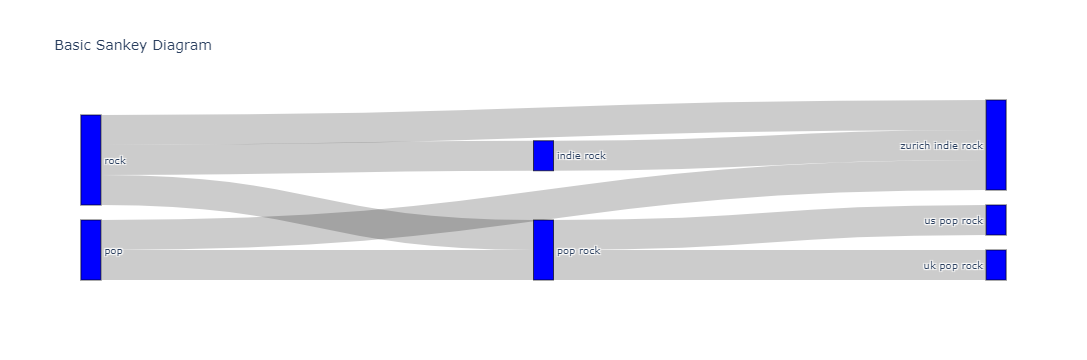

In [182]:
import plotly.graph_objects as go

label = [
    'rock',
    'pop',
    'indie rock',
    'pop rock',
    'zurich indie rock',
    'us pop rock',
    'uk pop rock',
]

source = [0, 0, 1, 2, 3, 3, 1, 0]
target = [2, 3, 3, 4, 5, 6, 4, 4]

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = label,
      color = "blue"
    ),
    link = dict(
      source = source,
      target = target,
      value = [1, 1, 1, 1, 1, 1, 1, 1],
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

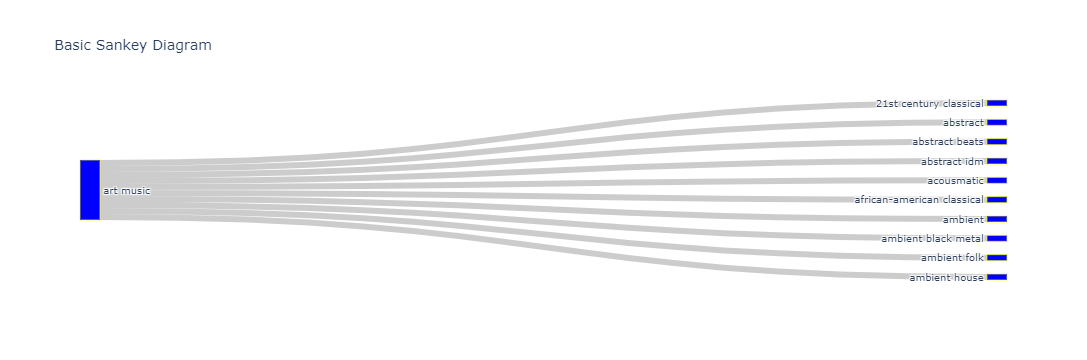

In [194]:
genres_dict = dict()
source = list()
target = list()
label = list()

top_genres = genres_df['top_genre'].unique()
for parent_genre in top_genres[:1]:
    parent_genre_df = genres_df.loc[genres_df['top_genre'] == parent_genre]
    sub_genres = parent_genre_df['spotify_genre'].unique()[:10]
    genres_dict[parent_genre] = list(sub_genres)
    for sub_genre in sub_genres:
        genres_dict[sub_genre] = list()

label = list(genres_dict.keys())
value = [1 for x in range(len(label))]

for parent_genre, sub_genres in genres_dict.items():
    parent_index = label.index(parent_genre)
    for sub_genre in sub_genres:
        sub_index = label.index(sub_genre)
        source.append(parent_index)
        target.append(sub_index)
        
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "yellow", width = 0.5),
      label = label,
      color = "blue"
    ),
    link = dict(
      source = source,
      target = target,
      value = value,
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

---
---

In [80]:
artists_multiple_matches_df = artists_df.loc[idx_list].sort_values(by=['spotify_name'])
#artists_multiple_matches_df.to_csv('data/spotify/data_spotify_artists_multiple_matches.csv', encoding='utf-8')
artists_multiple_matches_df

,artist_name,spotify_name,spotify_id,spotify_popularity,spotify_followers,spotify_listeners
artist_id,,,,,,
/artists/10119580-22deg-halo,22° Halo,22º Halo,6p355yiyJc67iSNeWLM8WH,11.0,1067.0,1500.0
/artists/9804639-22-halo,22 Halo,22º Halo,6p355yiyJc67iSNeWLM8WH,11.0,1067.0,1500.0
/artists/7309389-a-crashed-blackbird-rosehip,A Crashed Blackbird Rosehip,A Crashed Blackbird Called Rosehip,1NKizqgwDCXtUbMHeqA2Tv,6.0,88.0,635.0
/artists/6506249-a-crashed-blackbird-called-rosehip,A Crashed Blackbird Called Rosehip,A Crashed Blackbird Called Rosehip,1NKizqgwDCXtUbMHeqA2Tv,6.0,88.0,635.0
/artists/5990259-aspell,A-Spell,A.Spell,4zkmCFtAa1ETWHoZ2sNGvO,0.0,25.0,9.0
...,...,...,...,...,...,...
/artists/531180-za,Za!,Zaz,1mbgj8ERPs8lWi7t5cYrdy,65.0,1195585.0,2100000.0
/artists/25827-zippo,Zippo,Zippo,7Int2nVSzSBL8UDty3jGAR,23.0,1363.0,1300.0
/artists/7284179-zippo-italy,Zippo,Zippo,7Int2nVSzSBL8UDty3jGAR,23.0,1363.0,1300.0


In [101]:
with open('data/data_stats_artists_features.csv', encoding='utf-8') as file:
    artists_stats_features_df = pd.read_csv(file, index_col=0)

artists_stats_features_df

,nbr_venues,nbr_concerts,top_genres,spotify_genres,first_concert_date,last_concert_date,active_days,active_days_weighted,concert_frequency,nbr_tours,...,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,spotify_followers,spotify_listeners
/artists/10069604-flavio-stonex,5,8,[],[],2019-09-14,2019-12-07,85,0.0233,0.0941,1,...,-6.734889,0.059500,0.017928,3.138071e-01,0.270722,0.188178,129.355111,185672.222222,273.0,298.0
/artists/11032-jazz-connection,3,4,[],[],2016-11-11,2018-08-11,639,0.1750,0.0063,2,...,-12.038500,0.043710,0.417144,5.608000e-01,0.127100,0.411480,123.896300,270747.300000,287.0,3300.0
/artists/2865626-james-lann,2,2,"['world music', 'country music']",['texas country'],2012-08-08,2012-08-10,3,0.0008,0.6667,1,...,-6.829800,0.035230,0.113219,3.890000e-06,0.242200,0.530000,119.826300,210181.400000,2832.0,2800.0
/artists/8496013-trummer-ch,69,77,[],[],2015-04-25,2019-12-20,1701,0.4658,0.0453,4,...,-17.426800,0.075560,0.537670,8.836000e-01,0.135250,0.204320,103.248800,426677.200000,138.0,1700.0
/artists/8498548-vincent-vegas-last-dance,2,2,[],[],2015-07-10,2015-10-03,86,0.0235,0.0233,1,...,-8.088300,0.036190,0.093387,2.234647e-01,0.215420,0.300820,117.143000,294387.200000,38.0,410.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/artists/5592793-earl-sweatshirt,1,1,"['world music', 'hip hop music', 'experimental...","['alternative hip hop', 'experimental hip hop'...",2014-03-18,2014-03-18,1,0.0003,1.0000,0,...,-5.833700,0.271240,0.209620,3.490162e-02,0.358100,0.592700,127.013400,189189.700000,1588790.0,2900000.0
/artists/2699691-we-are-the-in-crowd,1,1,"['rock music', 'pop music', 'experimental music']","['pixie', 'pop punk', 'candy pop', 'pop emo', ...",2013-04-29,2013-04-29,1,0.0003,1.0000,0,...,-5.056100,0.095450,0.019808,0.000000e+00,0.147630,0.591700,156.753400,188237.800000,174869.0,220400.0
/artists/2338458-never-shout-never,1,1,"['pop music', 'rock music', 'experimental music']","['pop punk', 'pop emo', 'neon pop punk', 'alte...",2013-04-29,2013-04-29,1,0.0003,1.0000,0,...,-6.965100,0.108900,0.498920,3.610000e-07,0.208130,0.556400,107.266900,164591.200000,559407.0,650500.0
/artists/295364-propagandhi,1,1,"['rock music', 'folk music', 'world music']","['folk punk', 'canadian punk', 'skate punk', '...",2013-04-24,2013-04-24,1,0.0003,1.0000,0,...,-5.155900,0.084620,0.004794,2.422649e-03,0.323310,0.555300,125.837600,169032.000000,145115.0,185800.0


In [102]:
artists_stats_features_df.columns

Index(['nbr_venues', 'nbr_concerts', 'top_genres', 'spotify_genres',
       'first_concert_date', 'last_concert_date', 'active_days',
       'active_days_weighted', 'concert_frequency', 'nbr_tours',
       'avg_tour_concerts', 'avg_tour_days', 'tour_concert_frequency',
       'centroid_lat', 'centroid_lon', 'dist_centroid_total',
       'dist_centroid_mean', 'mobility', 'mobility_weighted_mean',
       'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'spotify_followers', 'spotify_listeners'],
      dtype='object')

<AxesSubplot:>

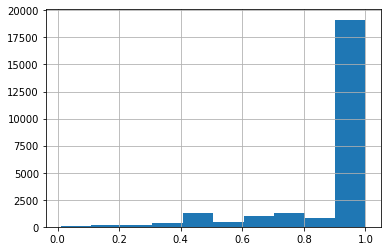

In [105]:
artists_filtered = artists_stats_features_df.loc[artists_stats_features_df['nbr_concerts'] > 0]
artists_filtered['mobility'].hist()

nbr concerts: 0
0 - 5063
0.0 - 1.0

nbr concerts: 1
2406 - 2657
0.475 - 0.5247876752913293

nbr concerts: 2
708 - 1949
0.14 - 0.38494963460398973

nbr concerts: 3
380 - 1569
0.075 - 0.3098953189808414

nbr concerts: 4
245 - 1324
0.048 - 0.26150503653960105

nbr concerts: 5
172 - 1152
0.034 - 0.22753308315228127

nbr concerts: 6
121 - 1031
0.024 - 0.2036342089670156

nbr concerts: 7
96 - 935
0.019 - 0.1846731187043255

nbr concerts: 8
94 - 841
0.019 - 0.16610705115544144

nbr concerts: 9
74 - 767
0.015 - 0.15149121074461783

nbr concerts: 10
51 - 716
0.01 - 0.1414181315425637

nbr concerts: 11
60 - 656
0.012 - 0.1295674501283824

nbr concerts: 12
46 - 610
0.009 - 0.12048192771084337

nbr concerts: 13
31 - 579
0.006 - 0.11435907564684969

nbr concerts: 14
30 - 549
0.006 - 0.10843373493975904

nbr concerts: 15
25 - 524
0.005 - 0.1034959510171835

nbr concerts: 16
15 - 509
0.003 - 0.10053328066363816

nbr concerts: 17
30 - 479
0.006 - 0.0946079399565475

nbr concerts: 18
16 - 463
0.003 - 0

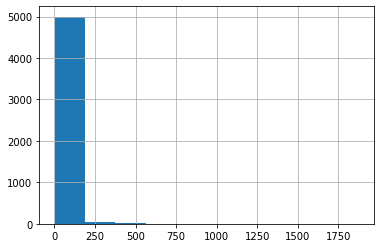

In [372]:
#venues_stats_genres.loc[venues_stats_genres['nbr_concerts'] > 10]['nbr_concerts'].hist()

venues_concerts_sum = full_data_df.groupby('venue_id')['concert_id'].nunique()
venues_concerts_sum.hist()
total_venues = len(venues_concerts_sum)
cum_venues = 0
cum_ratio = 0

for i in range(0, 51):
    print('nbr concerts:', i)
    #nbr_venues = len(venues_stats_genres.loc[venues_stats_genres['nbr_concerts'] == i])
    nbr_venues = len(venues_concerts_sum[venues_concerts_sum == i])
    ratio = round(nbr_venues / total_venues, 3)
    cum_venues += nbr_venues
    cum_ratio += ratio
    cum_ratio = round(cum_ratio, 3)
    print(nbr_venues, '-', total_venues - cum_venues)
    print(ratio, '-', (total_venues - cum_venues) / total_venues)
    
    print('')

In [373]:
venues_idx = venues_concerts_sum[venues_concerts_sum > 38].index
full_data_df.loc[full_data_df['venue_id'].isin(venues_idx)].nunique()

venue_id           251
concert_id       43595
artist_id        20439
spotify_genre     3422
top_genre           23
dtype: int64

In [189]:
full_data_df.nunique()

venue_id          5063
concert_id       62827
artist_id        24719
spotify_genre     3649
top_genre           23
dtype: int64

,artist_id
top_genre,
rock music,7685
world music,5739
electronic music,3951
pop music,3871
dance music,2832
hip hop music,2098
art music,1934
folk music,1522
independent music,1445


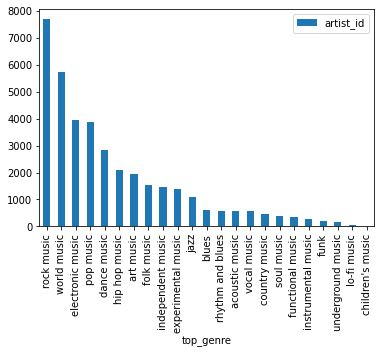

In [253]:
top_genres_by_artist = pd.DataFrame(full_data_df.groupby(['top_genre'])['artist_id'].nunique()).sort_values(by=['artist_id'], ascending=False)
top_genres_by_artist.plot.bar()
top_genres_by_artist

In [260]:
spotify_genres_by_artist = pd.DataFrame(full_data_df.groupby(['spotify_genre'])['artist_id'].nunique()).sort_values(by=['artist_id'], ascending=False)
spotify_genres_by_artist

,artist_id
spotify_genre,
rock,283
modern rock,246
indie rock,228
pop,222
dance pop,214
...,...
polish reggae,1
polish psychedelia,1
polish prog,1


<AxesSubplot:ylabel='Frequency'>

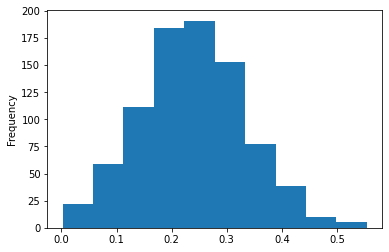

In [277]:
artists_stats_features_df.loc[artists_stats_features_df['nbr_venues'] > 10]['mobility_weighted_mean'].plot.hist()

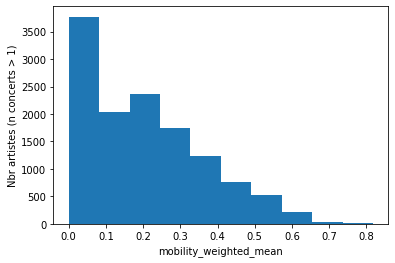

In [360]:
features = [
    'centroid_lat', 'centroid_lon', 'dist_centroid_total',
    'dist_centroid_mean', 'mobility', 'mobility_weighted_mean',
]

feature = 'mobility_weighted_mean'
min_concerts = 1

plot = artists_stats_features_df.loc[artists_stats_features_df['nbr_concerts'] > min_concerts][feature].plot.hist()
plot.set_xlabel(feature)
plot.set_ylabel('Nbr artistes (n concerts > ' + str(min_concerts) + ')')
fig = plot.get_figure()
fig.savefig('paper/images/plots/artists_distrib_' + feature, dpi=75)

In [282]:
artists_stats_features_df.columns

Index(['nbr_venues', 'nbr_concerts', 'top_genres', 'spotify_genres',
       'first_concert_date', 'last_concert_date', 'active_days',
       'active_days_weighted', 'concert_frequency', 'nbr_tours',
       'avg_tour_concerts', 'avg_tour_days', 'tour_concert_frequency',
       'centroid_lat', 'centroid_lon', 'dist_centroid_total',
       'dist_centroid_mean', 'mobility', 'mobility_weighted_mean',
       'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'spotify_followers', 'spotify_listeners'],
      dtype='object')

In [226]:
venues_idx = venues_concerts_sum[venues_concerts_sum == 10].index
sample = random.sample(list(venues_idx), k=30)
venues_df.loc[venues_df['venue_id'].isin(sample)]

,venue_id,linked_venue_id,venue,locality,latitude,longitude
377,/venues/1790878,/venues/1790878,Autonomer Beauty Salon,Zürich,NaN,NaN
726,/venues/533471,/venues/533471,Bodensee Arena,Kreuzlingen,47.65449,9.18001
747,/venues/713816,/venues/713816,Bonsoir Gmbh,Bern,46.94991,7.44310
907,/venues/1630963,/venues/1630963,CSOA Il Molino,Lugano,46.00862,8.95985
1191,/venues/1426653,/venues/1426653,Chez Fritz,Buchs,NaN,NaN
1323,/venues/4048444,/venues/4048444,Club To Groove,Chur,NaN,NaN
1370,/venues/3242579,/venues/3242579,Conservatoire Place Neuve,Geneva,46.20152,6.14385
1720,/venues/2479844,/venues/2479844,Elchclub,Bern,46.95840,7.48903
2110,/venues/4064909,/venues/4064909,Freiraum,Altstätten,47.40538,9.63498
2556,/venues/1995709,/venues/1995709,Hard One,Zürich,47.38854,8.52070


In [404]:
results_df = full_data_df.loc[full_data_df['artist_id'].isin(['/artists/10069604-flavio-stonex'])]
results_df = results_df.merge(venues_df[['latitude', 'longitude']], left_on='venue_id', right_index=True)
results_df

,venue_id,concert_id,artist_id,spotify_genre,top_genre,latitude,longitude
0,/venues/1943879,/festivals/3267425,/artists/10069604-flavio-stonex,NaN,NaN,47.04380,9.42400
1,/venues/1943879,/festivals/3250138,/artists/10069604-flavio-stonex,NaN,NaN,47.04380,9.42400
2,/venues/4353777,/festivals/3262463,/artists/10069604-flavio-stonex,NaN,NaN,47.04656,9.42147
3,/venues/4353777,/festivals/3243521,/artists/10069604-flavio-stonex,NaN,NaN,47.04656,9.42147
4,/venues/4353777,/festivals/3252459,/artists/10069604-flavio-stonex,NaN,NaN,47.04656,9.42147
5,/venues/3705034,/festivals/3231303,/artists/10069604-flavio-stonex,NaN,NaN,47.22969,8.67182
6,/venues/4345766,/festivals/3236713,/artists/10069604-flavio-stonex,NaN,NaN,47.01465,9.48952
7,/venues/4353394,/festivals/3251712,/artists/10069604-flavio-stonex,NaN,NaN,47.53199,7.63296


In [405]:
coord_cols = ['latitude', 'longitude']
venues_duplicated_coord = results_df.loc[results_df.duplicated(subset=['latitude', 'longitude'])].dropna(subset=['latitude', 'longitude'])
venues_duplicated_coord[coord_cols] = venues_duplicated_coord[coord_cols] + 0.00001
venues_duplicated_coord[coord_cols]

,latitude,longitude
1,47.04381,9.42401
3,47.04657,9.42148
4,47.04657,9.42148


In [406]:
results_df.loc[results_df.index.isin(venues_duplicated_coord.index), coord_cols] = venues_duplicated_coord[coord_cols]
#results_df.loc[venues_duplicated_coord.index][coord_cols] = venues_duplicated_coord[coord_cols]
results_df

,venue_id,concert_id,artist_id,spotify_genre,top_genre,latitude,longitude
0,/venues/1943879,/festivals/3267425,/artists/10069604-flavio-stonex,NaN,NaN,47.04380,9.42400
1,/venues/1943879,/festivals/3250138,/artists/10069604-flavio-stonex,NaN,NaN,47.04381,9.42401
2,/venues/4353777,/festivals/3262463,/artists/10069604-flavio-stonex,NaN,NaN,47.04656,9.42147
3,/venues/4353777,/festivals/3243521,/artists/10069604-flavio-stonex,NaN,NaN,47.04657,9.42148
4,/venues/4353777,/festivals/3252459,/artists/10069604-flavio-stonex,NaN,NaN,47.04657,9.42148
5,/venues/3705034,/festivals/3231303,/artists/10069604-flavio-stonex,NaN,NaN,47.22969,8.67182
6,/venues/4345766,/festivals/3236713,/artists/10069604-flavio-stonex,NaN,NaN,47.01465,9.48952
7,/venues/4353394,/festivals/3251712,/artists/10069604-flavio-stonex,NaN,NaN,47.53199,7.63296


In [431]:
test = [
    (47.04656, 9.42147)
]
break_count = 10
counter = 0
coord_base = [0, 0]
meaning = ['x', 'y']
coord = 0
sign = 1
lim = 1
curr = 0

while True:
    
    if curr == lim:
        curr = 0
        if coord == 0:
            sign = -1 * sign
            coord = 1
        else:
            lim += 1
            coord = 0
    
    coord_value = coord_base[coord]
    coord_value += 1 * sign
    coord_base[coord] = coord_value
    curr += 1
    print(meaning[coord], sign)
    print(coord_base)
    print(curr, lim)
    print('')
    
    if break_count == counter:
        break
    else:
        counter += 1

0 1
x 1
[1, 0]
1 1

0 1
y -1
[1, -1]
1 1

0 2
x -1
[0, -1]
1 2

1 2
x -1
[-1, -1]
2 2

0 2
y 1
[-1, 0]
1 2

1 2
y 1
[-1, 1]
2 2

0 3
x 1
[0, 1]
1 3

1 3
x 1
[1, 1]
2 3

2 3
x 1
[2, 1]
3 3

0 3
y -1
[2, 0]
1 3

1 3
y -1
[2, -1]
2 3

